Pemodelan dan Analitika Prediktif (A)
Kelompok 1
5026221039 Kevin Andreas Kurniawan Effendy
5026221067 Samuel Ba. Hutagalung
5026221076 Fresnel D. Siregar

# Initialization

In [ ]:
#Import file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import math

2024-06-29 12:19:41.838618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-29 12:19:42.000128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-29 12:19:42.000163: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-29 12:19:42.030856: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-29 12:19:42.711896: W tensorflow/stream_executor/pla

In [ ]:
df = pd.read_csv('Temp.csv', sep=';')
df

,Tanggal,Tavg
0,01-01-2020,"26,7"
1,02-01-2020,"26,3"
2,03-01-2020,"26,5"
3,04-01-2020,"26,3"
4,05-01-2020,"27,5"
...,...,...
1577,26-04-2024,"29,2"
1578,27-04-2024,"29,2"
1579,28-04-2024,"29,5"
1580,29-04-2024,"28,9"


In [ ]:
df['Tavg'] = df['Tavg'].str.replace(',', '.')
df['Tavg'] = df['Tavg'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1582 entries, 0 to 1581
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tanggal  1582 non-null   object 
 1   Tavg     1582 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.8+ KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1582 entries, 0 to 1581
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tanggal  1582 non-null   object 
 1   Tavg     1582 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.8+ KB


In [ ]:
df.describe

<bound method NDFrame.describe of          Tanggal  Tavg
0     01-01-2020  26.7
1     02-01-2020  26.3
2     03-01-2020  26.5
3     04-01-2020  26.3
4     05-01-2020  27.5
...          ...   ...
1577  26-04-2024  29.2
1578  27-04-2024  29.2
1579  28-04-2024  29.5
1580  29-04-2024  28.9
1581  30-04-2024  30.0

[1582 rows x 2 columns]>

# Data Preparation

In [ ]:
data_processing = df.copy()

In [ ]:
#Mengecek jumlah data yang duplikat
duplicate = data_processing.duplicated().sum()
print("Jumlah baris yang memiliki data sama: {} baris".format(duplicate))

Jumlah baris yang memiliki data sama: 0 baris


In [ ]:
#Mengecek data null
data_processing.isnull().sum()

Tanggal    0
Tavg       0
dtype: int64

Karena data telah diprocessing sebelumnya jadi tidak ada dideteksi nilai null dan baris yang sama pada bagian ini

In [ ]:
#Mengubah periode menjadi index
data_processing['Tanggal'] = pd.to_datetime(data_processing['Tanggal'], format='%d-%m-%Y')
data_processing = data_processing.set_index('Tanggal')
data_processing.info()
data_processing

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1582 entries, 2020-01-01 to 2024-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tavg    1582 non-null   float64
dtypes: float64(1)
memory usage: 24.7 KB


,Tavg
Tanggal,
2020-01-01,26.7
2020-01-02,26.3
2020-01-03,26.5
2020-01-04,26.3
2020-01-05,27.5
...,...
2024-04-26,29.2
2024-04-27,29.2
2024-04-28,29.5


Perubahan tanggal menjadi index dilakukan agar dapat membuat model pada time series

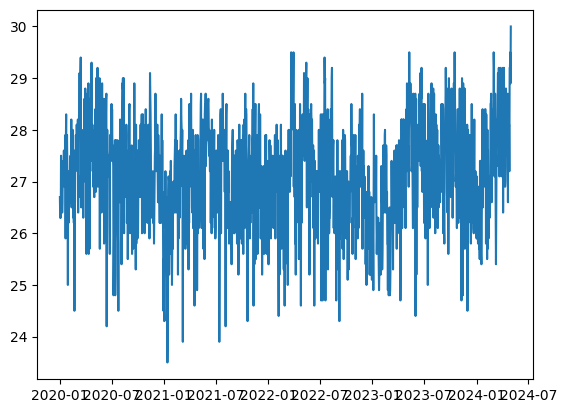

In [ ]:
#Plot variabel Tavg
plt.plot(data_processing)

# Parameter ARIMA

In [ ]:
data_arima = data_processing.copy()

In [ ]:
!pip install statsmodels==0.14.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 48.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Test adf

from statsmodels.tsa.stattools import adfuller

adf = adfuller(data_arima)

p_value = adf[1]
print(f'p-value = {p_value}')

p-value = 4.798797437303634e-12


In [ ]:
# analisis hasil ADF

if p_value < .05:
  print('Data stasioner')
else:
  print('Data tidak stasioner')

Data stasioner


Tidak ada parameter I karena data sudah stasioner (ARMA)

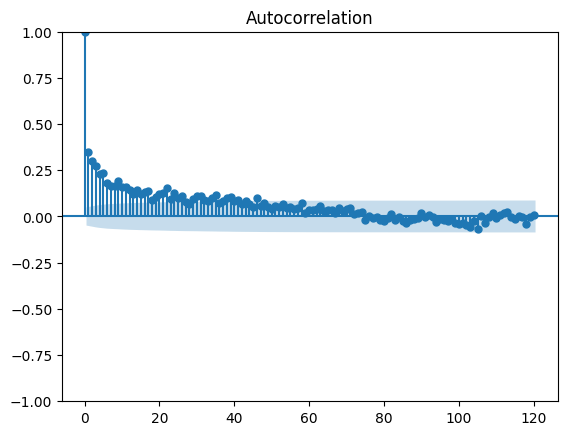

In [ ]:
# Plot ACF

from statsmodels.graphics.tsaplots import plot_acf

acf = plot_acf(data_arima, lags=120)

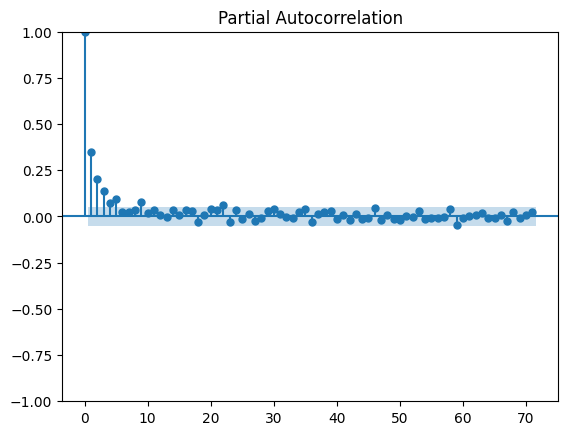

In [ ]:
# Plot PACF

from statsmodels.graphics.tsaplots import plot_pacf

pacf = plot_pacf(data_arima, lags=71)

Bedasarkan hasil ACF dan PACF maka didapatkan parameter optimal untuk ARMA ini adalah 1 dan 1

# Skema Hybrid ARIMA LSTM

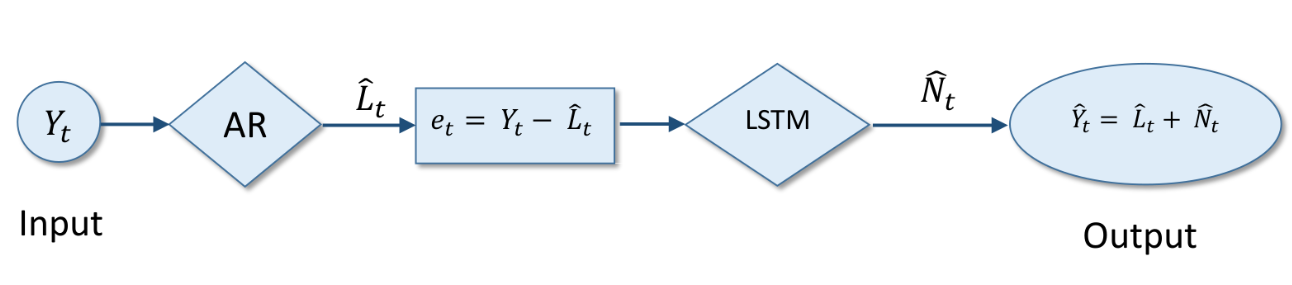

# Skenario 1 -Split Data 80:20

## ARIMA Model

In [ ]:
# Split dataset
train, test = train_test_split(data_arima, train_size = .8, test_size = .2, shuffle = False)

In [ ]:
# Print hasil train-test split

print(f'len data: {len(data_arima)}')
print(f'len train: {len(train)}')
print(f'len test: {len(test)}')

len data: 1582
len train: 1265
len test: 317


In [ ]:
# Buat model

from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train, order = (1, 0, 1)) # (order= auto regression(p), difference(d), moving average(q))

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# Fit Model

model_arima = model_arima.fit()

In [ ]:
# ARIMA Summary

print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                   Tavg   No. Observations:                 1265
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1652.639
Date:                Sat, 29 Jun 2024   AIC                           3313.278
Time:                        12:19:52   BIC                           3333.849
Sample:                    01-01-2020   HQIC                          3321.007
                         - 06-18-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.0587      0.083    327.467      0.000      26.897      27.221
ar.L1          0.9003      0.024     38.250      0.000       0.854       0.946
ma.L1         -0.6991      0.038    -18.346      0.0

In [ ]:
# Forecasting

start_test=len(train)
end_test=len(train)+len(test)-1
pred = model_arima.predict(start = start_test, end = end_test)

In [ ]:
#Hasil prediksi Tavg
test['Tavg_pred'] = pred.values
test

,Tavg,Tavg_pred
Tanggal,,
2023-06-19,27.3,27.911338
2023-06-20,28.9,27.826359
2023-06-21,28.6,27.749850
2023-06-22,29.2,27.680967
2023-06-23,27.2,27.618950
...,...,...
2024-04-26,29.2,27.058741
2024-04-27,29.2,27.058741
2024-04-28,29.5,27.058741


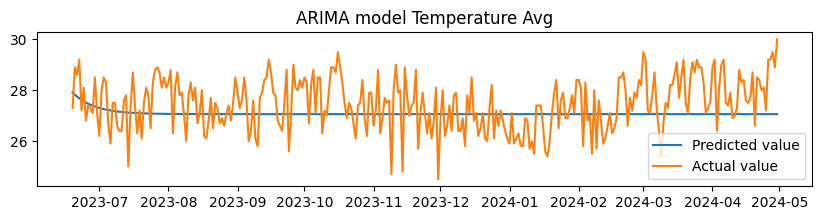

In [ ]:
#Plot model ARIMA dengan Temperature AVG
plt.figure(figsize=(10, 2))
plt.title("ARIMA model Temperature Avg")
plt.plot(test['Tavg_pred'], label="Predicted value")
plt.plot(test['Tavg'], label="Actual value")

plt.legend()
plt.show()


In [ ]:
#Menambahkan kolom residual
test['Tavg_residual'] = test['Tavg'] - test['Tavg_pred']
test

,Tavg,Tavg_pred,Tavg_residual
Tanggal,,,
2023-06-19,27.3,27.911338,-0.611338
2023-06-20,28.9,27.826359,1.073641
2023-06-21,28.6,27.749850,0.850150
2023-06-22,29.2,27.680967,1.519033
2023-06-23,27.2,27.618950,-0.418950
...,...,...,...
2024-04-26,29.2,27.058741,2.141259
2024-04-27,29.2,27.058741,2.141259
2024-04-28,29.5,27.058741,2.441259


In [ ]:
mse_arima1 = mean_squared_error(test['Tavg'], test['Tavg_pred'])
mae_arima1 = mean_absolute_error(test['Tavg'], test['Tavg_pred'])
mape_arima1 = mean_absolute_percentage_error(test['Tavg'], test['Tavg_pred'])*100

print(f'X_test MSE: {mse_arima1}')
print(f'X_test MAE: {mae_arima1}')
print('X_test MAPE:{}%'.format(mape_arima1))

X_test MSE: 1.1544800286185508
X_test MAE: 0.8839488192683164
X_test MAPE:3.1930181353743556%


## LSTM

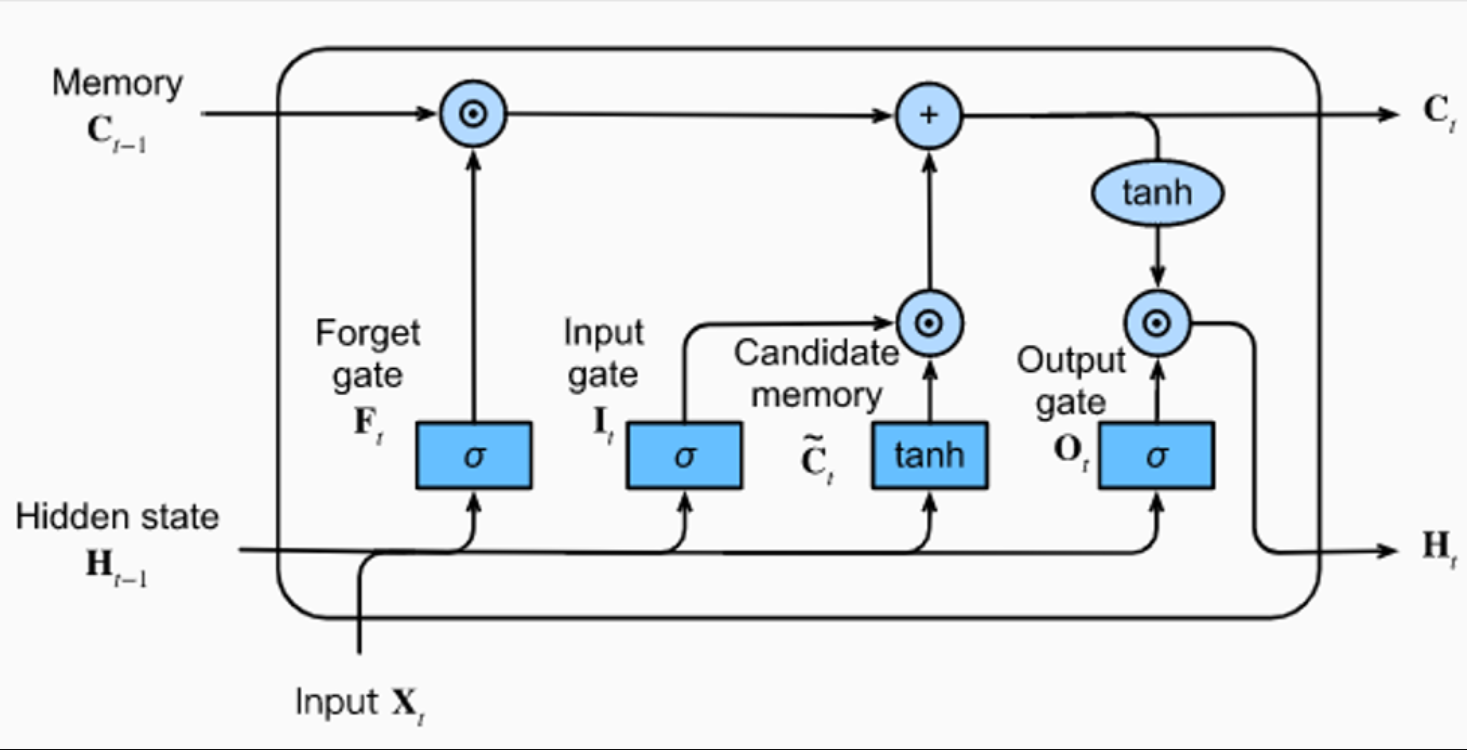

In [ ]:
#Inisialisasi data LSTM dengan menggunakan data residual
data_lstm=test.copy()
data_lstm.drop(columns = ['Tavg', 'Tavg_pred'], inplace = True)
data_lstm

,Tavg_residual
Tanggal,
2023-06-19,-0.611338
2023-06-20,1.073641
2023-06-21,0.850150
2023-06-22,1.519033
2023-06-23,-0.418950
...,...
2024-04-26,2.141259
2024-04-27,2.141259
2024-04-28,2.441259


In [ ]:
#Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scale_train = scaler.fit_transform(data_lstm.values.reshape(-1,1))

In [ ]:
# Split dataset
train_lstm_scaled, test_lstm_scaled = train_test_split(data_scale_train, train_size = .8, test_size = .2, shuffle = False)

In [ ]:
len(test_lstm_scaled), len(train_lstm_scaled)

(64, 253)

In [ ]:
X_train=[]
Y_train=[]

In [ ]:
len(train_lstm_scaled)

253

In [ ]:
# Fungsi untuk mendapatkan parameter time step terbaik

list_mse = []
list_step = [7,14,21,30]

for step in list_step:
  X_train=[]
  Y_train=[]
  for i in range(step, len(train_lstm_scaled)):
      X_train.append(train_lstm_scaled[i-step:i, 0])
      Y_train.append(train_lstm_scaled[i, 0])
  X_train, Y_train = np.array(X_train), np.array(Y_train)

  X_test=[]
  Y_test=[]
  for i in range(step, len(test_lstm_scaled)):
        X_test.append(test_lstm_scaled[i-step:i,0])
        Y_test.append(test_lstm_scaled[i,0])
  X_test,Y_test=np.array(X_test),np.array(Y_test)

  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  model = Sequential()
  model.add(LSTM(30, input_shape=(X_train.shape[1], 1)))
  model.add(Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

  model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=30,batch_size=64,verbose=1)

  # Predicting the values from fitted data

  train_predict=model.predict(X_train)
  test_predict=model.predict(X_test)

  mse = mean_squared_error(Y_test,test_predict)
  print("step ",step,"mse value:",mse)
  list_mse.append(mse)

list_mse

2024-06-29 12:19:53.545723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-29 12:19:53.545756: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-29 12:19:53.545775: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-2e3ead14-e1d1-4af7-8e7d-cb73e3d3639d): /proc/driver/nvidia/version does not exist
2024-06-29 12:19:53.546845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/30
4/4 [==============================] - 2s 167ms/step - loss: 0.30

[0.03558784541811555,
 0.033552288294925695,
 0.03156094044249703,
 0.03407906915938225]

In [ ]:
#Hasil parameter step terbaik
step = list_step[list_mse.index(min(list_mse))]
step

21

In [ ]:

X_train=[]
Y_train=[]
for i in range(step, len(train_lstm_scaled)):
  X_train.append(train_lstm_scaled[i-step:i, 0])
  Y_train.append(train_lstm_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_test=[]
Y_test=[]
for i in range(step, len(test_lstm_scaled)):
  X_test.append(test_lstm_scaled[i-step:i,0])
  Y_test.append(test_lstm_scaled[i,0])
X_test,Y_test=np.array(X_test),np.array(Y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(30, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model_lstm.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=30,batch_size=64,verbose=1)

#Memprediksi nilai dari fit model

train_predict=model_lstm.predict(X_train)
test_predict=model_lstm.predict(X_test)

Epoch 1/30
4/4 [==============================] - 2s 172ms/step - loss: 0.3638 - accuracy: 0.0043 - val_loss: 0.4956 - val_accuracy: 0.0000e+00
Epoch 2/30
4/4 [==============================] - 0s 32ms/step - loss: 0.2626 - accuracy: 0.0043 - val_loss: 0.3488 - val_accuracy: 0.0000e+00
Epoch 3/30
4/4 [==============================] - 0s 30ms/step - loss: 0.1792 - accuracy: 0.0043 - val_loss: 0.2222 - val_accuracy: 0.0000e+00
Epoch 4/30
4/4 [==============================] - 0s 31ms/step - loss: 0.1048 - accuracy: 0.0043 - val_loss: 0.1186 - val_accuracy: 0.0000e+00
Epoch 5/30
4/4 [==============================] - 0s 32ms/step - loss: 0.0554 - accuracy: 0.0043 - val_loss: 0.0490 - val_accuracy: 0.0233
Epoch 6/30
4/4 [==============================] - 0s 35ms/step - loss: 0.0459 - accuracy: 0.0000e+00 - val_loss: 0.0268 - val_accuracy: 0.0233
Epoch 7/30
4/4 [==============================] - 0s 30ms/step - loss: 0.0505 - accuracy: 0.0000e+00 - val_loss: 0.0270 - val_accuracy: 0.0233
Ep

In [ ]:
# Model training
history = model_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=64, verbose=1)

Epoch 1/30
4/4 [==============================] - 0s 48ms/step - loss: 0.0359 - accuracy: 0.0043 - val_loss: 0.0351 - val_accuracy: 0.0233
Epoch 2/30
4/4 [==============================] - 0s 35ms/step - loss: 0.0367 - accuracy: 0.0000e+00 - val_loss: 0.0363 - val_accuracy: 0.0233
Epoch 3/30
4/4 [==============================] - 0s 33ms/step - loss: 0.0335 - accuracy: 0.0043 - val_loss: 0.0366 - val_accuracy: 0.0233
Epoch 4/30
4/4 [==============================] - 0s 32ms/step - loss: 0.0338 - accuracy: 0.0043 - val_loss: 0.0359 - val_accuracy: 0.0233
Epoch 5/30
4/4 [==============================] - 0s 17ms/step - loss: 0.0361 - accuracy: 0.0043 - val_loss: 0.0347 - val_accuracy: 0.0233
Epoch 6/30
4/4 [==============================] - 0s 33ms/step - loss: 0.0367 - accuracy: 0.0043 - val_loss: 0.0329 - val_accuracy: 0.0233
Epoch 7/30
4/4 [==============================] - 0s 37ms/step - loss: 0.0353 - accuracy: 0.0000e+00 - val_loss: 0.0327 - val_accuracy: 0.0233
Epoch 8/30
4/4 [===

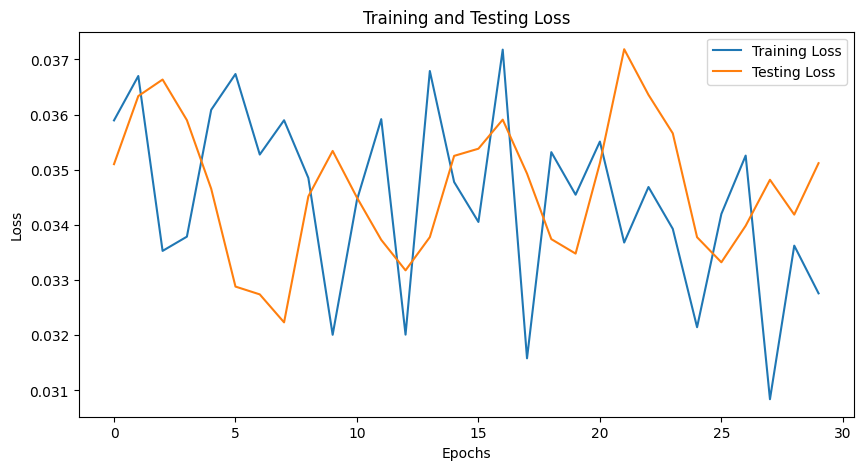

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
mse_lstm1 = mean_squared_error(Y_test,test_predict)
mae_lstm1 = mean_absolute_error(Y_test,test_predict)
mape_lstm1 = mean_absolute_percentage_error(Y_test,test_predict)*100

print(f'X_test MSE: {mse_lstm1}')
print(f'X_test MAE: {mae_lstm1}')
print('X_test MAPE:{}%'.format(mape_lstm1))

X_test MSE: 0.03527591263288355
X_test MAE: 0.16021457215620943
X_test MAPE:23.221105541985477%


In [ ]:
test_predict

array([[0.5467559 ],
       [0.5599676 ],
       [0.56315464],
       [0.56198347],
       [0.5648495 ],
       [0.572276  ],
       [0.58007586],
       [0.5910677 ],
       [0.60011667],
       [0.6082836 ],
       [0.61308384],
       [0.6095402 ],
       [0.60448724],
       [0.59741294],
       [0.5972495 ],
       [0.6011206 ],
       [0.59017473],
       [0.5865875 ],
       [0.5883078 ],
       [0.59334046],
       [0.59121525],
       [0.58661735],
       [0.5829444 ],
       [0.57439935],
       [0.5652144 ],
       [0.55602485],
       [0.55553395],
       [0.55576277],
       [0.5580849 ],
       [0.5570448 ],
       [0.55485135],
       [0.5534063 ],
       [0.5583742 ],
       [0.55219823],
       [0.5548394 ],
       [0.5571411 ],
       [0.5582131 ],
       [0.5617693 ],
       [0.55858815],
       [0.56518275],
       [0.5737564 ],
       [0.587015  ],
       [0.59770936]], dtype=float32)

In [ ]:
len(test_predict)

43

In [ ]:
test_tavg_last = test['Tavg_pred'][len(test['Tavg_pred'])-len(test_predict):]
test_tavg_last = np.array(test_tavg_last)
test_tavg_last

array([27.05874092, 27.05874092, 27.05874092, 27.05874092, 27.05874092,
       27.05874092, 27.05874092, 27.05874092, 27.05874092, 27.05874092,
       27.05874092, 27.05874092, 27.05874092, 27.05874092, 27.05874092,
       27.05874092, 27.05874092, 27.05874092, 27.05874092, 27.05874092,
       27.05874092, 27.05874092, 27.05874092, 27.05874092, 27.05874092,
       27.05874092, 27.05874092, 27.05874092, 27.05874092, 27.05874092,
       27.05874092, 27.05874092, 27.05874092, 27.05874092, 27.05874092,
       27.05874092, 27.05874092, 27.05874092, 27.05874092, 27.05874092,
       27.05874092, 27.05874092, 27.05874092])

In [ ]:
forecast_inverse = scaler.inverse_transform(test_predict)

In [ ]:
forecast_inverse

array([[0.4484166 ],
       [0.52108073],
       [0.53860956],
       [0.53216815],
       [0.5479313 ],
       [0.58877707],
       [0.6316763 ],
       [0.6921313 ],
       [0.74190074],
       [0.78681874],
       [0.8132202 ],
       [0.7937303 ],
       [0.7659389 ],
       [0.7270303 ],
       [0.7261314 ],
       [0.74742234],
       [0.6872201 ],
       [0.66749024],
       [0.67695194],
       [0.70463157],
       [0.692943  ],
       [0.6676545 ],
       [0.64745325],
       [0.6004555 ],
       [0.54993826],
       [0.49939576],
       [0.4966958 ],
       [0.4979543 ],
       [0.51072603],
       [0.5050055 ],
       [0.49294153],
       [0.48499373],
       [0.5123173 ],
       [0.47834936],
       [0.49287564],
       [0.50553524],
       [0.5114312 ],
       [0.53099024],
       [0.5134939 ],
       [0.54976416],
       [0.59691924],
       [0.6698414 ],
       [0.7286605 ]], dtype=float32)

In [ ]:
#Penambahan data prediksi ARIMA dan prediksi residual LSTM
predicted_tavg = [0 for _ in range(len(test_predict))]
for i in range(len(forecast_inverse)):
  predicted_tavg[i] = forecast_inverse[i][0]+test_tavg_last[i]

predicted_tavg

[27.507157511918567,
 27.579821653573507,
 27.597350485532253,
 27.590909071176,
 27.60667223474257,
 27.647517986504944,
 27.690417237489118,
 27.75087220212686,
 27.800641663281784,
 27.845559663979863,
 27.871961124150598,
 27.85247123977406,
 27.824679799287146,
 27.78577119847995,
 27.784872300832085,
 27.80616325875978,
 27.745961017815866,
 27.72623116513947,
 27.735692866055757,
 27.76337248822906,
 27.751683898179312,
 27.726395435540454,
 27.706194169728533,
 27.659196443764937,
 27.608679182736644,
 27.558136679141292,
 27.555436707942253,
 27.556695230214363,
 27.56946695586896,
 27.563746400086643,
 27.551682449786423,
 27.543734647242783,
 27.571058221070526,
 27.537090279071087,
 27.55161655685162,
 27.5642761661694,
 27.57017213842129,
 27.589731164185757,
 27.572234816758385,
 27.608505077569237,
 27.655660159795037,
 27.728582329957238,
 27.787401445119134]

In [ ]:
#Dataframe data aktual dan hasil prediksi hybrid ARIMA LSTM
df_aktual = pd.DataFrame(test['Tavg'][len(test['Tavg'])-len(test_predict):])
df_aktual['Tavg_pred']=predicted_tavg
df_aktual

,Tavg,Tavg_pred
Tanggal,,
2024-03-19,29.2,27.507158
2024-03-20,27.5,27.579822
2024-03-21,27.1,27.597350
2024-03-22,28.4,27.590909
2024-03-23,29.1,27.606672
2024-03-24,28.7,27.647518
2024-03-25,29.2,27.690417
2024-03-26,28.9,27.750872
2024-03-27,28.9,27.800642


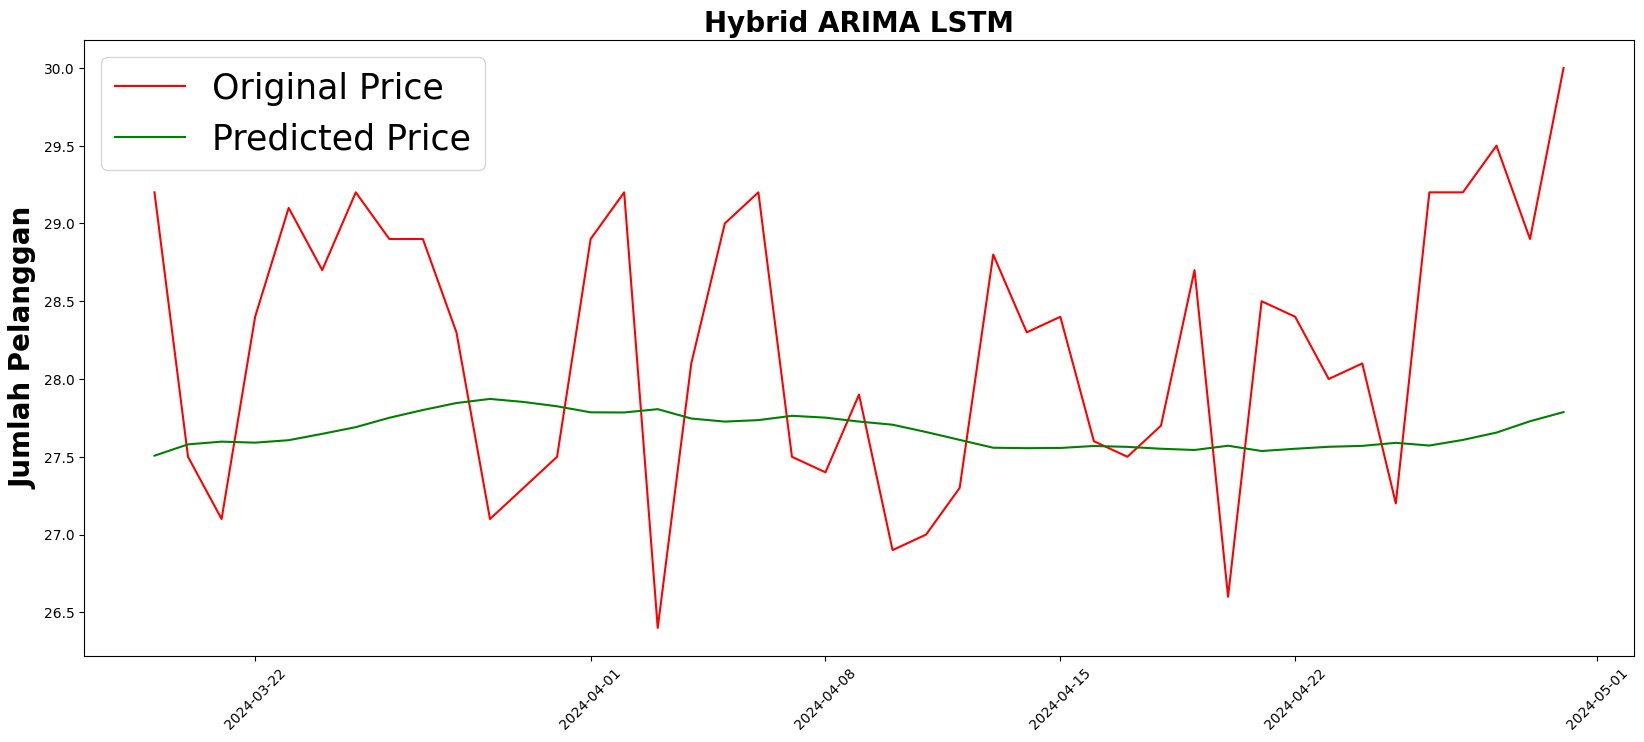

In [ ]:
#Plot hybrid ARIMA LSTM
plt.figure(figsize=(20,8))
plt.plot(df_aktual['Tavg'], label='Original Price', color='red')
plt.plot(df_aktual['Tavg_pred'], label='Predicted Price', color='green')
plt.title('Hybrid ARIMA LSTM', fontweight='bold', fontsize=20)
plt.ylabel('Jumlah Pelanggan', fontweight='bold', fontsize=20)
plt.xticks(rotation=45)
plt.legend(prop={'size':25})
plt.show()

In [ ]:
#Hasil Error dari Hybrid LSTM
mse1 = mean_squared_error(df_aktual['Tavg'],df_aktual['Tavg_pred'])
mae1 = mean_absolute_error(df_aktual['Tavg'],df_aktual['Tavg_pred'])
mape1 = mean_absolute_percentage_error(df_aktual['Tavg'],df_aktual['Tavg_pred'])*100

print(f'X_test MSE: {mse1}')
print(f'X_test MAE: {mae1}')
print('X_test MAPE:{}%'.format(mape1))

X_test MSE: 1.067096360192829
X_test MAE: 0.8811801473038828
X_test MAPE:3.08657754780841%


Terjadi pengurangan MAPE dari model ARIMA sebelumnya

## Prediksi 1 Tahun ke Depan

In [ ]:
step

21

In [ ]:
target_pred = 365

In [ ]:
initial_state = np.array(predicted_tavg.copy())

In [ ]:
for _ in range(len(forecast_inverse),len(forecast_inverse)+ target_pred):
  predicted_tavg.append(0)

In [ ]:
initial_state

array([27.50715751, 27.57982165, 27.59735049, 27.59090907, 27.60667223,
       27.64751799, 27.69041724, 27.7508722 , 27.80064166, 27.84555966,
       27.87196112, 27.85247124, 27.8246798 , 27.7857712 , 27.7848723 ,
       27.80616326, 27.74596102, 27.72623117, 27.73569287, 27.76337249,
       27.7516839 , 27.72639544, 27.70619417, 27.65919644, 27.60867918,
       27.55813668, 27.55543671, 27.55669523, 27.56946696, 27.5637464 ,
       27.55168245, 27.54373465, 27.57105822, 27.53709028, 27.55161656,
       27.56427617, 27.57017214, 27.58973116, 27.57223482, 27.60850508,
       27.65566016, 27.72858233, 27.78740145])

In [ ]:
forecast_resid = []

current = np.array(data_lstm[-len(test_predict):]).reshape(1, len(test_predict), 1)

for _ in range(target_pred):
    current_pred = model_lstm.predict(current,steps = step)
    forecast_resid.append(current_pred.flatten())
    current = np.append(current[: , 1:, :], [current_pred], axis = 1)

forecast_resid

21/21 [==============================] - 0s 665us/step


[array([0.9951698], dtype=float32),
 array([0.9870764], dtype=float32),
 array([0.98859406], dtype=float32),
 array([0.9796483], dtype=float32),
 array([0.9635032], dtype=float32),
 array([0.94295305], dtype=float32),
 array([0.9199038], dtype=float32),
 array([0.8956804], dtype=float32),
 array([0.8711749], dtype=float32),
 array([0.84699875], dtype=float32),
 array([0.8235446], dtype=float32),
 array([0.8010552], dtype=float32),
 array([0.7796936], dtype=float32),
 array([0.75952995], dtype=float32),
 array([0.74059963], dtype=float32),
 array([0.7228702], dtype=float32),
 array([0.7062604], dtype=float32),
 array([0.6907919], dtype=float32),
 array([0.67638993], dtype=float32),
 array([0.6629798], dtype=float32),
 array([0.6504722], dtype=float32),
 array([0.6388332], dtype=float32),
 array([0.6280137], dtype=float32),
 array([0.61793125], dtype=float32),
 array([0.608554], dtype=float32),
 array([0.5998357], dtype=float32),
 array([0.5917481], dtype=float32),
 array([0.5842128], dt

In [ ]:
start_test=len(data_processing)
end_test= start_test + target_pred-1

forecast_arima = model_arima.predict(start = start_test, end = end_test)

In [ ]:
forecast = [resid + arima for resid, arima in zip(forecast_resid, forecast_arima)]

In [ ]:
len(forecast_arima)

365

In [ ]:
forecast = pd.DataFrame(forecast, index=forecast_arima.index)
forecast

,0
2024-05-01,28.053911
2024-05-02,28.045816
2024-05-03,28.047335
2024-05-04,28.038389
2024-05-05,28.022243
...,...
2025-04-26,27.540899
2025-04-27,27.540899
2025-04-28,27.540899
2025-04-29,27.540899


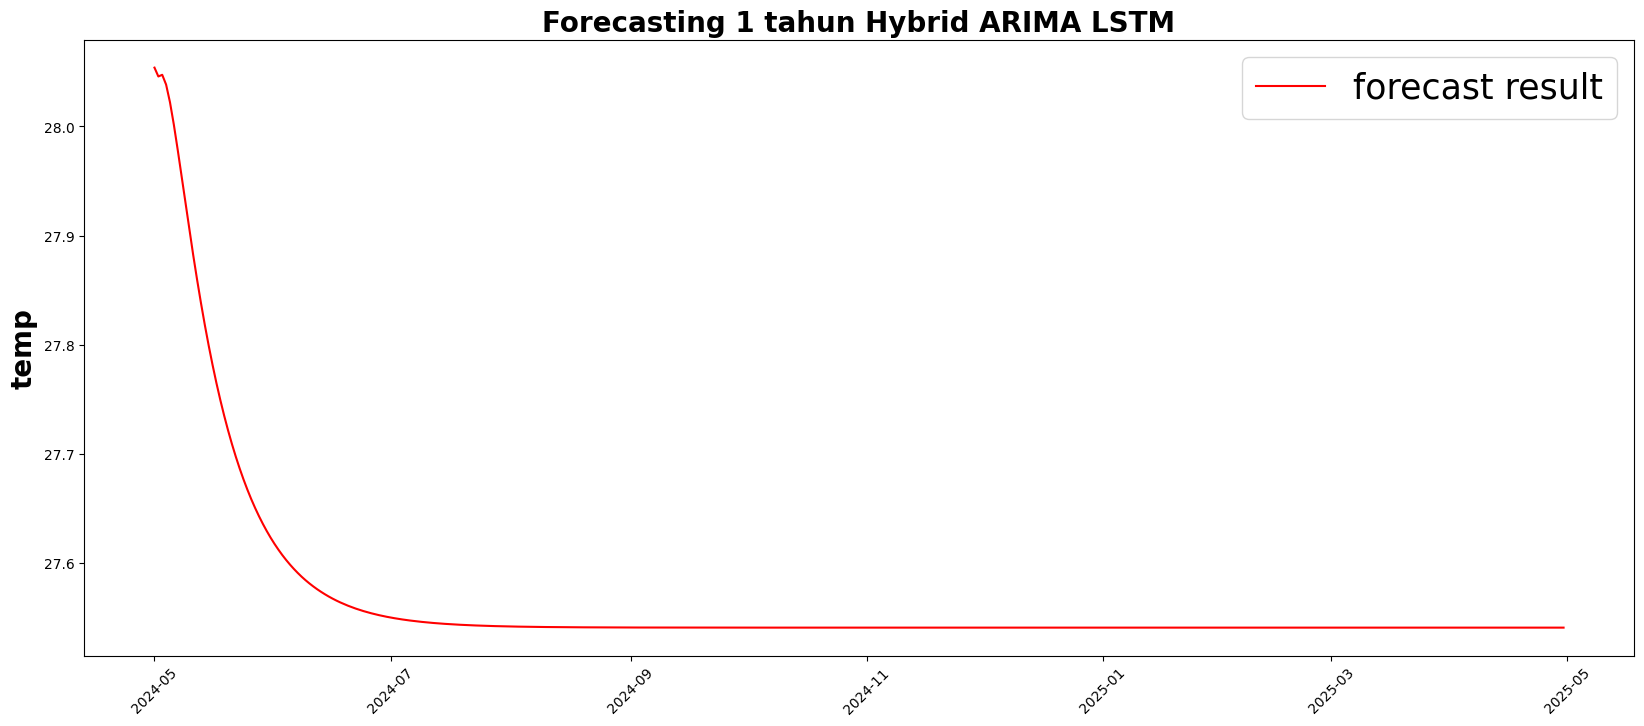

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(forecast, label='forecast result', color='red')
plt.title('Forecasting 1 tahun Hybrid ARIMA LSTM', fontweight='bold', fontsize=20)
plt.ylabel('temp', fontweight='bold', fontsize=20)
plt.xticks(rotation=45)
plt.legend(prop={'size':25})
plt.show()

In [ ]:
forecast

,0
2024-05-01,28.053911
2024-05-02,28.045816
2024-05-03,28.047335
2024-05-04,28.038389
2024-05-05,28.022243
...,...
2025-04-26,27.540899
2025-04-27,27.540899
2025-04-28,27.540899
2025-04-29,27.540899


# Skenario 2 - Split Data 70:30

## ARIMA Model

In [ ]:
# Split dataset
train, test = train_test_split(data_arima, train_size = .7, test_size = .3, shuffle = False)

In [ ]:
# Print hasil train-test split

print(f'len data: {len(data_arima)}')
print(f'len train: {len(train)}')
print(f'len test: {len(test)}')

len data: 1582
len train: 1107
len test: 475


In [ ]:
# Buat model

from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train, order = (1, 0, 1)) # (order= auto regression(p), difference(d), moving average(q))

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# Fit Model

model_arima = model_arima.fit()

In [ ]:
# ARIMA Summary

print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                   Tavg   No. Observations:                 1107
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1452.895
Date:                Sat, 29 Jun 2024   AIC                           2913.790
Time:                        12:20:55   BIC                           2933.827
Sample:                    01-01-2020   HQIC                          2921.368
                         - 01-11-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.0640      0.077    352.565      0.000      26.914      27.214
ar.L1          0.8768      0.030     28.982      0.000       0.818       0.936
ma.L1         -0.6807      0.046    -14.690      0.0

In [ ]:
# Forecasting

start_test=len(train)
end_test=len(train)+len(test)-1
pred = model_arima.predict(start = start_test, end = end_test)

In [ ]:
#Hasil prediksi Tavg
test['Tavg_pred'] = pred.values
test

,Tavg,Tavg_pred
Tanggal,,
2023-01-12,27.1,27.087411
2023-01-13,26.8,27.084531
2023-01-14,27.5,27.082006
2023-01-15,26.2,27.079793
2023-01-16,25.6,27.077852
...,...,...
2024-04-26,29.2,27.064034
2024-04-27,29.2,27.064034
2024-04-28,29.5,27.064034


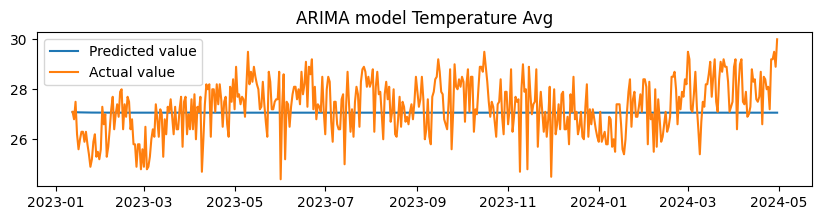

In [ ]:
#Plot model ARIMA dengan Temperature AVG
plt.figure(figsize=(10, 2))
plt.title("ARIMA model Temperature Avg")
plt.plot(test['Tavg_pred'], label="Predicted value")
plt.plot(test['Tavg'], label="Actual value")

plt.legend()
plt.show()


In [ ]:
#Menambahkan kolom residual
test['Tavg_residual'] = test['Tavg'] - test['Tavg_pred']
test

,Tavg,Tavg_pred,Tavg_residual
Tanggal,,,
2023-01-12,27.1,27.087411,0.012589
2023-01-13,26.8,27.084531,-0.284531
2023-01-14,27.5,27.082006,0.417994
2023-01-15,26.2,27.079793,-0.879793
2023-01-16,25.6,27.077852,-1.477852
...,...,...,...
2024-04-26,29.2,27.064034,2.135966
2024-04-27,29.2,27.064034,2.135966
2024-04-28,29.5,27.064034,2.435966


In [ ]:
mse_arima2 = mean_squared_error(test['Tavg'], test['Tavg_pred'])
mae_arima2 = mean_absolute_error(test['Tavg'], test['Tavg_pred'])
mape_arima2 = mean_absolute_percentage_error(test['Tavg'], test['Tavg_pred'])*100

print(f'X_test MSE: {mse_arima2}')
print(f'X_test MAE: {mae_arima2}')
print('X_test MAPE:{}%'.format(mape_arima2))

X_test MSE: 1.1614601344979516
X_test MAE: 0.88491250399829
X_test MAPE:3.2349510893930282%


## LSTM

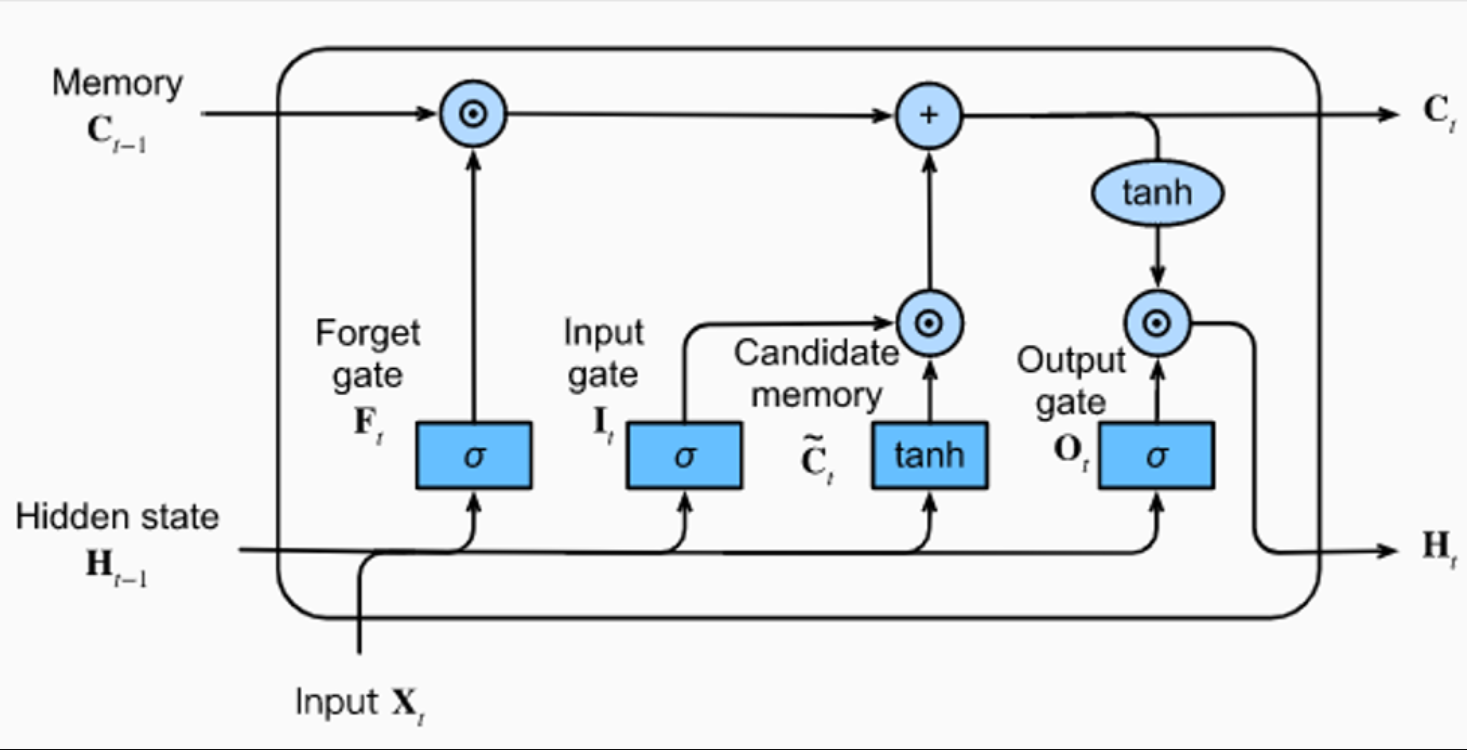

In [ ]:
#Inisialisasi data LSTM dengan menggunakan data residual
data_lstm=test.copy()
data_lstm.drop(columns = ['Tavg', 'Tavg_pred'], inplace = True)
data_lstm

,Tavg_residual
Tanggal,
2023-01-12,0.012589
2023-01-13,-0.284531
2023-01-14,0.417994
2023-01-15,-0.879793
2023-01-16,-1.477852
...,...
2024-04-26,2.135966
2024-04-27,2.135966
2024-04-28,2.435966


In [ ]:
#Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scale_train = scaler.fit_transform(data_lstm.values.reshape(-1,1))

In [ ]:
# Split dataset
train_lstm_scaled, test_lstm_scaled = train_test_split(data_scale_train, train_size = .7, test_size = .3, shuffle = False)

In [ ]:
len(test_lstm_scaled), len(train_lstm_scaled)

(143, 332)

In [ ]:
X_train=[]
Y_train=[]

In [ ]:
len(train_lstm_scaled)

332

In [ ]:
# Fungsi untuk mendapatkan parameter time step terbaik

list_mse = []
list_step = [7,14,21,30]

for step in list_step:
  X_train=[]
  Y_train=[]
  for i in range(step, len(train_lstm_scaled)):
      X_train.append(train_lstm_scaled[i-step:i, 0])
      Y_train.append(train_lstm_scaled[i, 0])
  X_train, Y_train = np.array(X_train), np.array(Y_train)

  X_test=[]
  Y_test=[]
  for i in range(step, len(test_lstm_scaled)):
        X_test.append(test_lstm_scaled[i-step:i,0])
        Y_test.append(test_lstm_scaled[i,0])
  X_test,Y_test=np.array(X_test),np.array(Y_test)

  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  model = Sequential()
  model.add(LSTM(30, input_shape=(X_train.shape[1], 1)))
  model.add(Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

  model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=30,batch_size=64,verbose=1)

  # Predicting the values from fitted data

  train_predict=model.predict(X_train)
  test_predict=model.predict(X_test)

  mse = mean_squared_error(Y_test,test_predict)
  print("step ",step,"mse value:",mse)
  list_mse.append(mse)

list_mse

Epoch 1/30
6/6 [==============================] - 2s 103ms/step - loss: 0.2290 - accuracy: 0.0031 - val_loss: 0.1706 - val_accuracy: 0.0000e+00
Epoch 2/30
6/6 [==============================] - 0s 15ms/step - loss: 0.1246 - accuracy: 0.0031 - val_loss: 0.0813 - val_accuracy: 0.0000e+00
Epoch 3/30
6/6 [==============================] - 0s 20ms/step - loss: 0.0583 - accuracy: 0.0031 - val_loss: 0.0352 - val_accuracy: 0.0074
Epoch 4/30
6/6 [==============================] - 0s 17ms/step - loss: 0.0367 - accuracy: 0.0000e+00 - val_loss: 0.0271 - val_accuracy: 0.0074
Epoch 5/30
6/6 [==============================] - 0s 18ms/step - loss: 0.0425 - accuracy: 0.0000e+00 - val_loss: 0.0301 - val_accuracy: 0.0074
Epoch 6/30
6/6 [==============================] - 0s 20ms/step - loss: 0.0427 - accuracy: 0.0000e+00 - val_loss: 0.0272 - val_accuracy: 0.0074
Epoch 7/30
6/6 [==============================] - 0s 16ms/step - loss: 0.0372 - accuracy: 0.0000e+00 - val_loss: 0.0267 - val_accuracy: 0.0074
Ep

[0.026925319939516353,
 0.02626906422693544,
 0.028013893242467593,
 0.029022786688173752]

In [ ]:
#Hasil parameter step terbaik
step = list_step[list_mse.index(min(list_mse))]
step

14

In [ ]:
step = list_step[list_mse.index(min(list_mse))]
X_train=[]
Y_train=[]
for i in range(step, len(train_lstm_scaled)):
  X_train.append(train_lstm_scaled[i-step:i, 0])
  Y_train.append(train_lstm_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_test=[]
Y_test=[]
for i in range(step, len(test_lstm_scaled)):
  X_test.append(test_lstm_scaled[i-step:i,0])
  Y_test.append(test_lstm_scaled[i,0])
X_test,Y_test=np.array(X_test),np.array(Y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(30, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model_lstm.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=30,batch_size=64,verbose=1)

#Memprediksi nilai dari fit model

train_predict=model_lstm.predict(X_train)
test_predict=model_lstm.predict(X_test)

Epoch 1/30
5/5 [==============================] - 2s 132ms/step - loss: 0.2211 - accuracy: 0.0031 - val_loss: 0.1940 - val_accuracy: 0.0000e+00
Epoch 2/30
5/5 [==============================] - 0s 28ms/step - loss: 0.1354 - accuracy: 0.0031 - val_loss: 0.1123 - val_accuracy: 0.0000e+00
Epoch 3/30
5/5 [==============================] - 0s 27ms/step - loss: 0.0763 - accuracy: 0.0031 - val_loss: 0.0519 - val_accuracy: 0.0000e+00
Epoch 4/30
5/5 [==============================] - 0s 22ms/step - loss: 0.0410 - accuracy: 0.0031 - val_loss: 0.0272 - val_accuracy: 0.0078
Epoch 5/30
5/5 [==============================] - 0s 25ms/step - loss: 0.0395 - accuracy: 0.0000e+00 - val_loss: 0.0306 - val_accuracy: 0.0078
Epoch 6/30
5/5 [==============================] - 0s 26ms/step - loss: 0.0400 - accuracy: 0.0000e+00 - val_loss: 0.0277 - val_accuracy: 0.0078
Epoch 7/30
5/5 [==============================] - 0s 27ms/step - loss: 0.0361 - accuracy: 0.0000e+00 - val_loss: 0.0277 - val_accuracy: 0.0078
Ep

In [ ]:
# Model training
history = model_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=64, verbose=1)

Epoch 1/30
5/5 [==============================] - 0s 29ms/step - loss: 0.0316 - accuracy: 0.0000e+00 - val_loss: 0.0281 - val_accuracy: 0.0078
Epoch 2/30
5/5 [==============================] - 0s 23ms/step - loss: 0.0299 - accuracy: 0.0000e+00 - val_loss: 0.0280 - val_accuracy: 0.0078
Epoch 3/30
5/5 [==============================] - 0s 25ms/step - loss: 0.0316 - accuracy: 0.0031 - val_loss: 0.0276 - val_accuracy: 0.0078
Epoch 4/30
5/5 [==============================] - 0s 27ms/step - loss: 0.0298 - accuracy: 0.0031 - val_loss: 0.0273 - val_accuracy: 0.0078
Epoch 5/30
5/5 [==============================] - 0s 30ms/step - loss: 0.0319 - accuracy: 0.0000e+00 - val_loss: 0.0277 - val_accuracy: 0.0078
Epoch 6/30
5/5 [==============================] - 0s 17ms/step - loss: 0.0325 - accuracy: 0.0031 - val_loss: 0.0283 - val_accuracy: 0.0078
Epoch 7/30
5/5 [==============================] - 0s 23ms/step - loss: 0.0297 - accuracy: 0.0031 - val_loss: 0.0284 - val_accuracy: 0.0078
Epoch 8/30
5/5 

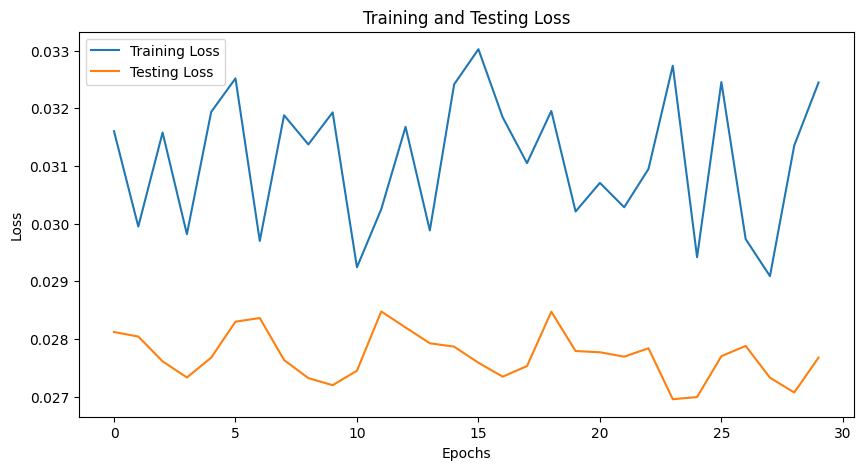

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
mse_lstm2 = mean_squared_error(Y_test,test_predict)
mae_lstm2 = mean_absolute_error(Y_test,test_predict)
mape_lstm2 = mean_absolute_percentage_error(Y_test,test_predict)*100

print(f'X_test MSE: {mse_lstm2}')
print(f'X_test MAE: {mae_lstm2}')
print('X_test MAPE:{}%'.format(mape_lstm2))

X_test MSE: 0.028209356068315424
X_test MAE: 0.14252936456837015
X_test MAPE:30.495602654831792%


In [ ]:
test_predict

array([[0.44101822],
       [0.45715404],
       [0.45246366],
       [0.4580715 ],
       [0.45432588],
       [0.45782351],
       [0.45582607],
       [0.4510736 ],
       [0.4408042 ],
       [0.42820925],
       [0.42909914],
       [0.4179728 ],
       [0.40996665],
       [0.40477785],
       [0.3929303 ],
       [0.38031945],
       [0.38487613],
       [0.38990828],
       [0.38428792],
       [0.37921908],
       [0.3685149 ],
       [0.38038027],
       [0.396853  ],
       [0.41538078],
       [0.4226869 ],
       [0.41626343],
       [0.40224975],
       [0.39298797],
       [0.39852992],
       [0.41688725],
       [0.44325697],
       [0.4505949 ],
       [0.46606594],
       [0.48372012],
       [0.48994306],
       [0.4893339 ],
       [0.49151033],
       [0.4995545 ],
       [0.50170934],
       [0.51809025],
       [0.5365229 ],
       [0.5506543 ],
       [0.53451025],
       [0.5393834 ],
       [0.5295846 ],
       [0.5228459 ],
       [0.4959787 ],
       [0.496

In [ ]:
len(test_predict)

129

In [ ]:
test_tavg_last = test['Tavg_pred'][len(test['Tavg_pred'])-len(test_predict):]
test_tavg_last = np.array(test_tavg_last)
test_tavg_last

array([27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06403419,
       27.06403419, 27.06403419, 27.06403419, 27.06403419, 27.06

In [ ]:
forecast_inverse = scaler.inverse_transform(test_predict)

In [ ]:
forecast_inverse

array([[-1.94332138e-01],
       [-1.03971586e-01],
       [-1.30237713e-01],
       [-9.88337845e-02],
       [-1.19809233e-01],
       [-1.00222506e-01],
       [-1.11408174e-01],
       [-1.38022095e-01],
       [-1.95530593e-01],
       [-2.66062409e-01],
       [-2.61078984e-01],
       [-3.23386490e-01],
       [-3.68220955e-01],
       [-3.97278190e-01],
       [-4.63624507e-01],
       [-5.34245312e-01],
       [-5.08727849e-01],
       [-4.80547786e-01],
       [-5.12021840e-01],
       [-5.40407300e-01],
       [-6.00350797e-01],
       [-5.33904672e-01],
       [-4.41657394e-01],
       [-3.37901831e-01],
       [-2.96987534e-01],
       [-3.32958966e-01],
       [-4.11435574e-01],
       [-4.63301569e-01],
       [-4.32266653e-01],
       [-3.29465568e-01],
       [-1.81795135e-01],
       [-1.40702739e-01],
       [-5.40649071e-02],
       [ 4.47985046e-02],
       [ 7.96469301e-02],
       [ 7.62356371e-02],
       [ 8.84236693e-02],
       [ 1.33471102e-01],
       [ 1.4

In [ ]:
#Penambahan data prediksi ARIMA dan prediksi residual LSTM
predicted_tavg = [0 for _ in range(len(test_predict))]
for i in range(len(forecast_inverse)):
  predicted_tavg[i] = forecast_inverse[i][0]+test_tavg_last[i]

predicted_tavg

[26.869702051590913,
 26.960062603663438,
 26.933796475838655,
 26.965200404833787,
 26.94422495664262,
 26.963811683665746,
 26.952626015256875,
 26.926012094329828,
 26.868503595899575,
 26.797971780609124,
 26.802955205749505,
 26.740647698949807,
 26.69581323416137,
 26.66675599963569,
 26.60040968210601,
 26.52978887708091,
 26.555306340764993,
 26.583486403535836,
 26.552012349676126,
 26.523626889299386,
 26.463683392118448,
 26.530129517625802,
 26.622376795124048,
 26.72613235862159,
 26.767046655725473,
 26.731075222801202,
 26.652598615001672,
 26.600732620071405,
 26.631767536710733,
 26.734568621229165,
 26.88223905415439,
 26.92333144993686,
 27.00996928216123,
 27.108832693855994,
 27.143681119393342,
 27.140269826363557,
 27.152457858633035,
 27.197505290817254,
 27.209572310756677,
 27.301305393885606,
 27.40452837498092,
 27.48366403133773,
 27.393257434677118,
 27.420547093461984,
 27.36567368657493,
 27.327937181304925,
 27.177480797480577,
 27.179254199575418,
 27.

In [ ]:
#Dataframe data aktual dan hasil prediksi hybrid ARIMA LSTM
df_aktual = pd.DataFrame(test['Tavg'][len(test['Tavg'])-len(test_predict):])
df_aktual['Tavg_pred']=predicted_tavg
df_aktual

,Tavg,Tavg_pred
Tanggal,,
2023-12-24,28.2,26.869702
2023-12-25,26.1,26.960063
2023-12-26,27.2,26.933796
2023-12-27,26.6,26.965200
2023-12-28,27.2,26.944225
...,...,...
2024-04-26,29.2,27.644929
2024-04-27,29.2,27.717503
2024-04-28,29.5,27.801663


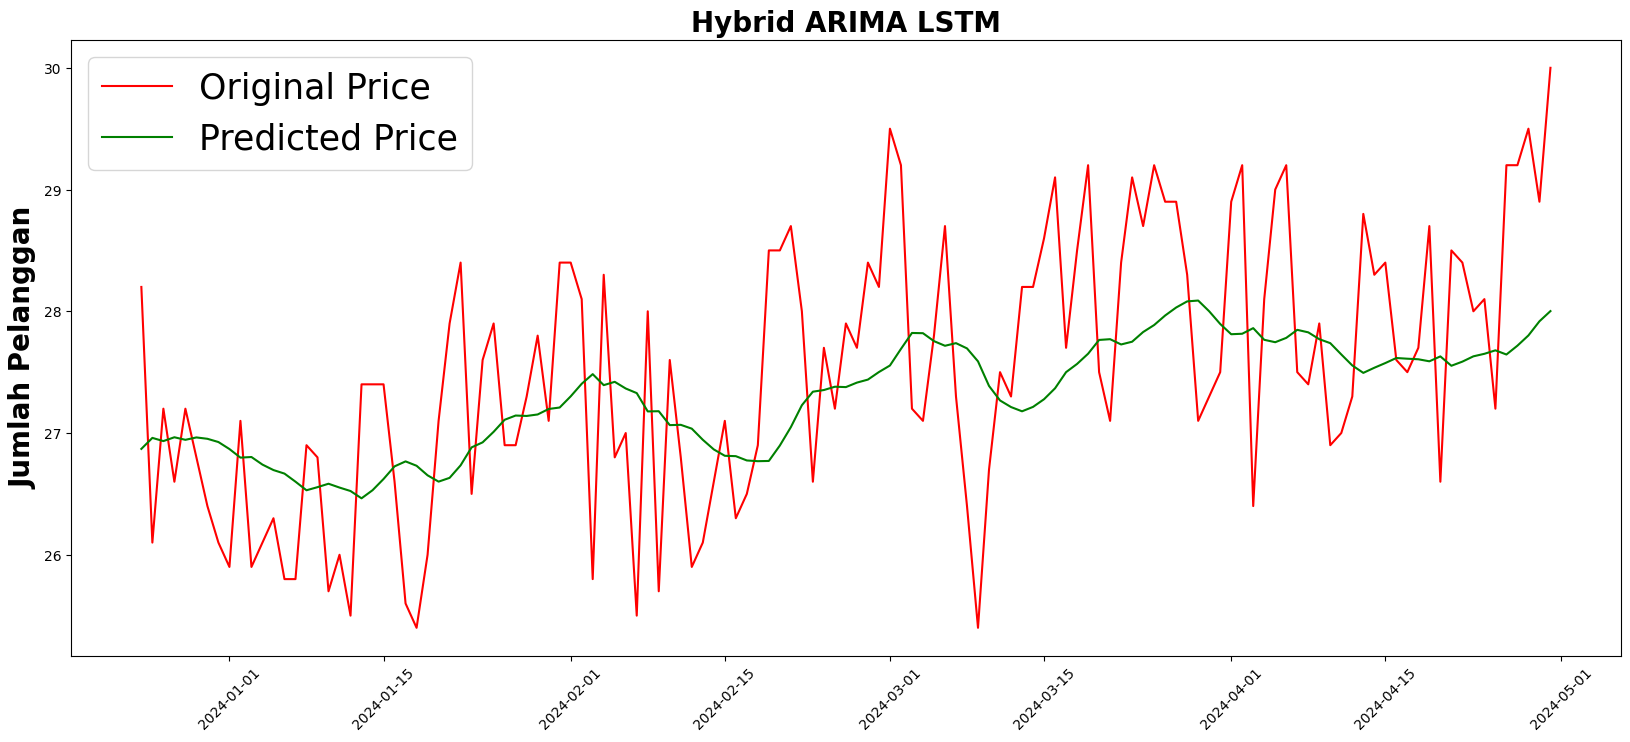

In [ ]:
#Plot hybrid ARIMA LSTM
plt.figure(figsize=(20,8))
plt.plot(df_aktual['Tavg'], label='Original Price', color='red')
plt.plot(df_aktual['Tavg_pred'], label='Predicted Price', color='green')
plt.title('Hybrid ARIMA LSTM', fontweight='bold', fontsize=20)
plt.ylabel('Jumlah Pelanggan', fontweight='bold', fontsize=20)
plt.xticks(rotation=45)
plt.legend(prop={'size':25})
plt.show()

In [ ]:
#Hasil Error dari Hybrid LSTM
mse2 = mean_squared_error(df_aktual['Tavg'],df_aktual['Tavg_pred'])
mae2 = mean_absolute_error(df_aktual['Tavg'],df_aktual['Tavg_pred'])
mape2 = mean_absolute_percentage_error(df_aktual['Tavg'],df_aktual['Tavg_pred'])*100

print(f'X_test MSE: {mse2}')
print(f'X_test MAE: {mae2}')
print('X_test MAPE:{}%'.format(mape2))

X_test MSE: 0.8846454095701591
X_test MAE: 0.7981644431725605
X_test MAPE:2.8879585155794647%


Terjadi pengurangan MAPE dari model ARIMA sebelumnya

## Prediksi 1 Tahun ke Depan

In [ ]:
step

14

In [ ]:
target_pred = 365

In [ ]:
initial_state = np.array(predicted_tavg.copy())

In [ ]:
for _ in range(len(forecast_inverse),len(forecast_inverse)+ target_pred):
  predicted_tavg.append(0)

In [ ]:
initial_state

array([26.86970205, 26.9600626 , 26.93379648, 26.9652004 , 26.94422496,
       26.96381168, 26.95262602, 26.92601209, 26.8685036 , 26.79797178,
       26.80295521, 26.7406477 , 26.69581323, 26.666756  , 26.60040968,
       26.52978888, 26.55530634, 26.5834864 , 26.55201235, 26.52362689,
       26.46368339, 26.53012952, 26.6223768 , 26.72613236, 26.76704666,
       26.73107522, 26.65259862, 26.60073262, 26.63176754, 26.73456862,
       26.88223905, 26.92333145, 27.00996928, 27.10883269, 27.14368112,
       27.14026983, 27.15245786, 27.19750529, 27.20957231, 27.30130539,
       27.40452837, 27.48366403, 27.39325743, 27.42054709, 27.36567369,
       27.32793718, 27.1774808 , 27.1792542 , 27.06498606, 27.06740017,
       27.03588276, 26.94457543, 26.86524951, 26.81304606, 26.80990696,
       26.77468201, 26.76873347, 26.77060064, 26.89728529, 27.04841509,
       27.22821593, 27.33959132, 27.35318675, 27.38040098, 27.37725773,
       27.41417613, 27.43890133, 27.5009745 , 27.55461093, 27.69

In [ ]:
forecast_resid = []

current = np.array(data_lstm[-len(test_predict):]).reshape(1, len(test_predict), 1)

for _ in range(target_pred):
    current_pred = model_lstm.predict(current,steps = step)
    forecast_resid.append(current_pred.flatten())
    current = np.append(current[: , 1:, :], [current_pred], axis = 1)

forecast_resid

14/14 [==============================] - 0s 1ms/step


[array([1.1692085], dtype=float32),
 array([1.1952617], dtype=float32),
 array([1.1825415], dtype=float32),
 array([1.1542562], dtype=float32),
 array([1.1186393], dtype=float32),
 array([1.0799654], dtype=float32),
 array([1.0406042], dtype=float32),
 array([1.0018873], dtype=float32),
 array([0.9645518], dtype=float32),
 array([0.9289887], dtype=float32),
 array([0.8953861], dtype=float32),
 array([0.8638129], dtype=float32),
 array([0.83426607], dtype=float32),
 array([0.80670106], dtype=float32),
 array([0.7810489], dtype=float32),
 array([0.75722635], dtype=float32),
 array([0.7351426], dtype=float32),
 array([0.7147032], dtype=float32),
 array([0.6958122], dtype=float32),
 array([0.6783744], dtype=float32),
 array([0.66229606], dtype=float32),
 array([0.6474863], dtype=float32),
 array([0.633857], dtype=float32),
 array([0.6213242], dtype=float32),
 array([0.6098074], dtype=float32),
 array([0.59923065], dtype=float32),
 array([0.5895225], dtype=float32),
 array([0.58061504], dty

In [ ]:
start_test=len(data_processing)
end_test= start_test + target_pred-1

forecast_arima = model_arima.predict(start = start_test, end = end_test)

In [ ]:
forecast = [resid + arima for resid, arima in zip(forecast_resid, forecast_arima)]

In [ ]:
len(forecast_arima)

365

In [ ]:
forecast = pd.DataFrame(forecast, index=forecast_arima.index)
forecast

,0
2024-05-01,28.233242
2024-05-02,28.259295
2024-05-03,28.246574
2024-05-04,28.218290
2024-05-05,28.182673
...,...
2025-04-26,27.548401
2025-04-27,27.548401
2025-04-28,27.548401
2025-04-29,27.548401


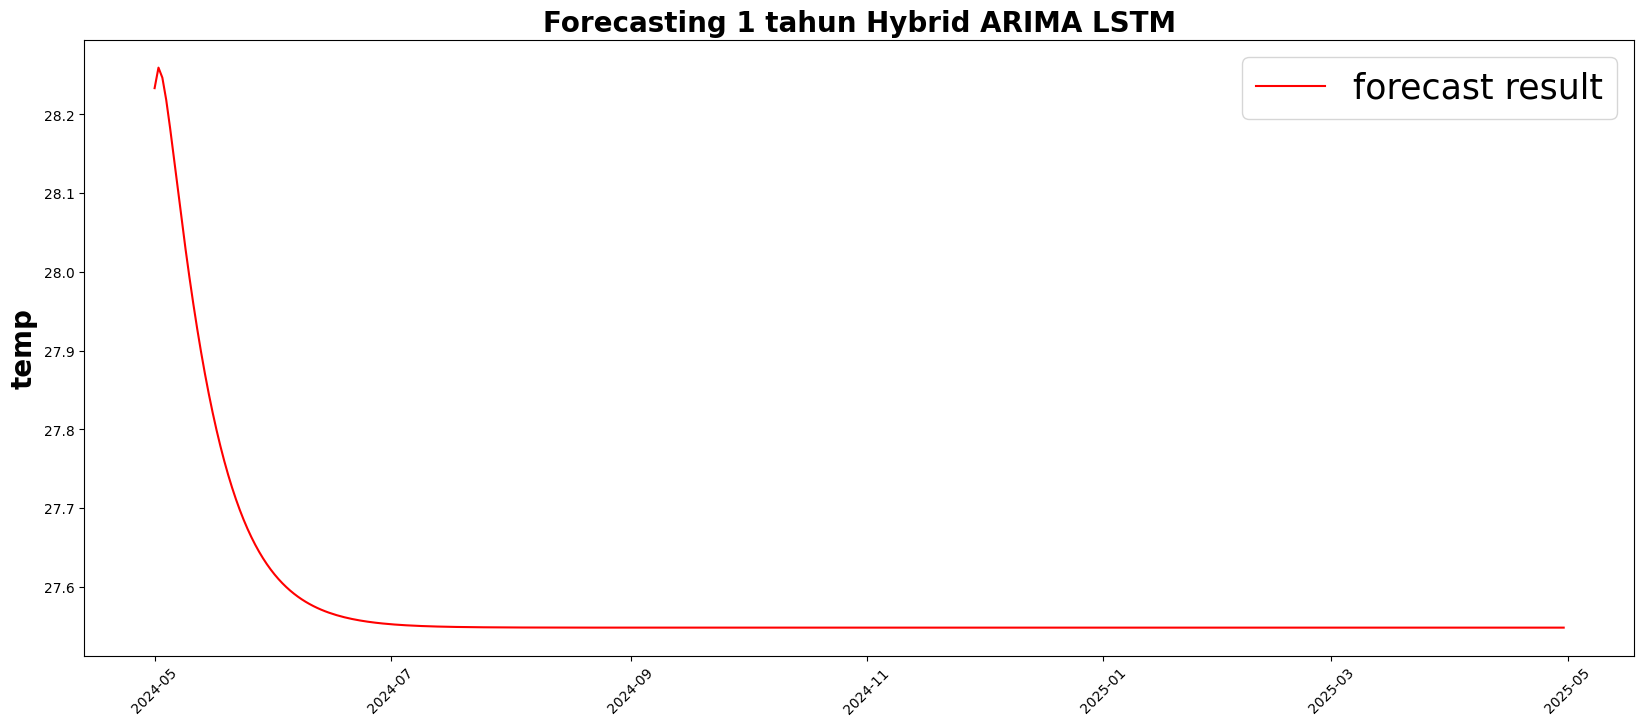

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(forecast, label='forecast result', color='red')
plt.title('Forecasting 1 tahun Hybrid ARIMA LSTM', fontweight='bold', fontsize=20)
plt.ylabel('temp', fontweight='bold', fontsize=20)
plt.xticks(rotation=45)
plt.legend(prop={'size':25})
plt.show()

In [ ]:
forecast

,0
2024-05-01,28.233242
2024-05-02,28.259295
2024-05-03,28.246574
2024-05-04,28.218290
2024-05-05,28.182673
...,...
2025-04-26,27.548401
2025-04-27,27.548401
2025-04-28,27.548401
2025-04-29,27.548401


# Skenario 3 - Split data 60:40

## ARIMA Model

In [ ]:
# Split dataset
train, test = train_test_split(data_arima, train_size = .6, test_size = .4, shuffle = False)

In [ ]:
# Print hasil train-test split

print(f'len data: {len(data_arima)}')
print(f'len train: {len(train)}')
print(f'len test: {len(test)}')

len data: 1582
len train: 949
len test: 633


In [ ]:
# Buat model

from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train, order = (1, 0, 1)) # (order= auto regression(p), difference(d), moving average(q))

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# Fit Model

model_arima = model_arima.fit()

In [ ]:
# ARIMA Summary

print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                   Tavg   No. Observations:                  949
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1261.044
Date:                Sat, 29 Jun 2024   AIC                           2530.088
Time:                        12:22:02   BIC                           2549.510
Sample:                    01-01-2020   HQIC                          2537.489
                         - 08-06-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.1106      0.082    331.400      0.000      26.950      27.271
ar.L1          0.8725      0.034     25.409      0.000       0.805       0.940
ma.L1         -0.6822      0.051    -13.261      0.0

In [ ]:
# Forecasting

start_test=len(train)
end_test=len(train)+len(test)-1
pred = model_arima.predict(start = start_test, end = end_test)

In [ ]:
#Hasil prediksi Tavg
test['Tavg_pred'] = pred.values
test

,Tavg,Tavg_pred
Tanggal,,
2022-08-07,27.2,27.085989
2022-08-08,28.4,27.089126
2022-08-09,27.8,27.091862
2022-08-10,28.1,27.094250
2022-08-11,29.0,27.096334
...,...,...
2024-04-26,29.2,27.110595
2024-04-27,29.2,27.110595
2024-04-28,29.5,27.110595


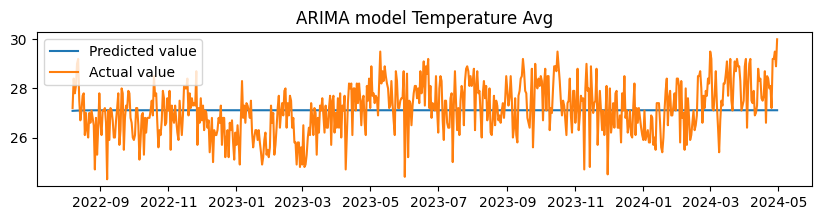

In [ ]:
#Plot model ARIMA dengan Temperature AVG
plt.figure(figsize=(10, 2))
plt.title("ARIMA model Temperature Avg")
plt.plot(test['Tavg_pred'], label="Predicted value")
plt.plot(test['Tavg'], label="Actual value")

plt.legend()
plt.show()


In [ ]:
#Menambahkan kolom residual
test['Tavg_residual'] = test['Tavg'] - test['Tavg_pred']
test

,Tavg,Tavg_pred,Tavg_residual
Tanggal,,,
2022-08-07,27.2,27.085989,0.114011
2022-08-08,28.4,27.089126,1.310874
2022-08-09,27.8,27.091862,0.708138
2022-08-10,28.1,27.094250,1.005750
2022-08-11,29.0,27.096334,1.903666
...,...,...,...
2024-04-26,29.2,27.110595,2.089405
2024-04-27,29.2,27.110595,2.089405
2024-04-28,29.5,27.110595,2.389405


In [ ]:
mse_arima3 = mean_squared_error(test['Tavg'], test['Tavg_pred'])
mae_arima3 = mean_absolute_error(test['Tavg'], test['Tavg_pred'])
mape_arima3 = mean_absolute_percentage_error(test['Tavg'], test['Tavg_pred'])*100

print(f'X_test MSE: {mse_arima3}')
print(f'X_test MAE: {mae_arima3}')
print('X_test MAPE:{}%'.format(mape_arima3))

X_test MSE: 1.0676407597276039
X_test MAE: 0.8352219446222985
X_test MAPE:3.08049955757735%


## LSTM

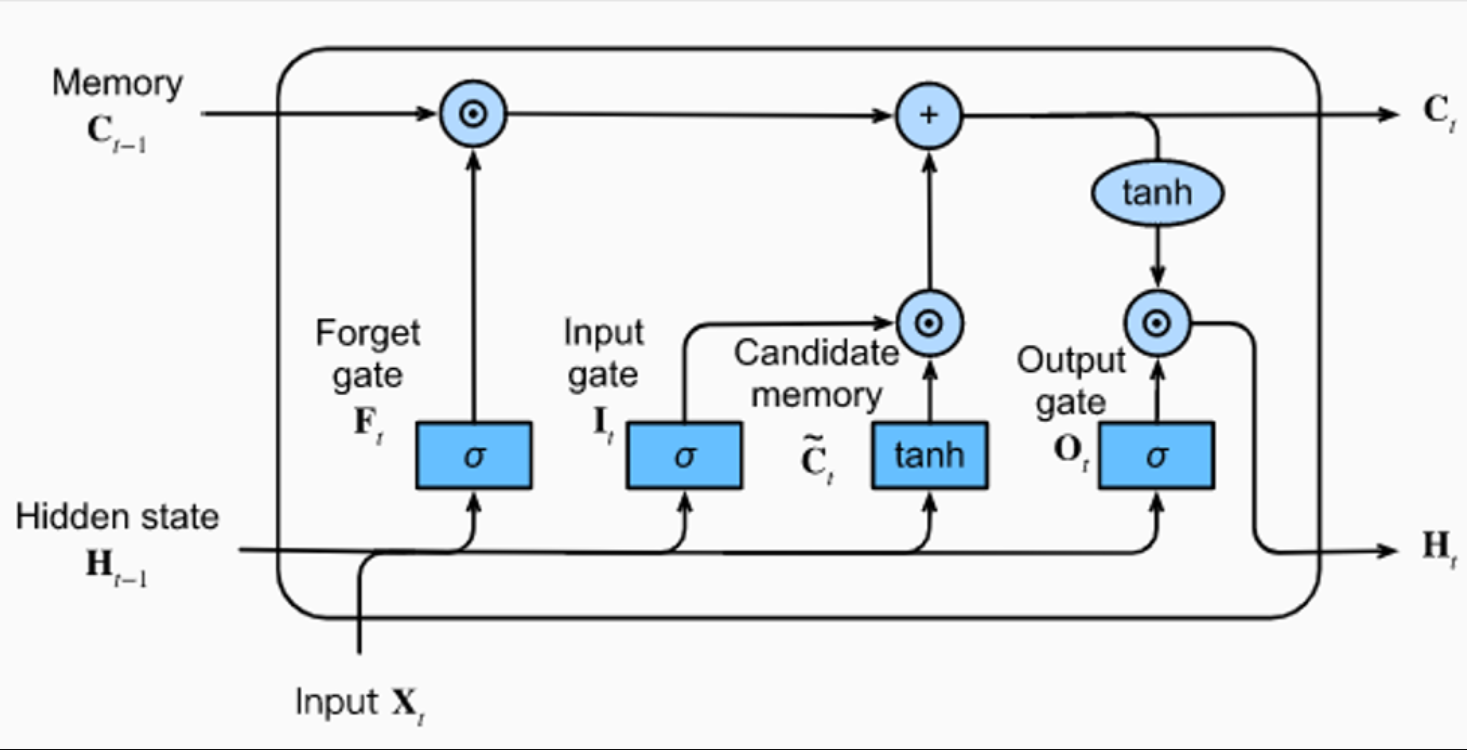

In [ ]:
#Inisialisasi data LSTM dengan menggunakan data residual
data_lstm=test.copy()
data_lstm.drop(columns = ['Tavg', 'Tavg_pred'], inplace = True)
data_lstm

,Tavg_residual
Tanggal,
2022-08-07,0.114011
2022-08-08,1.310874
2022-08-09,0.708138
2022-08-10,1.005750
2022-08-11,1.903666
...,...
2024-04-26,2.089405
2024-04-27,2.089405
2024-04-28,2.389405


In [ ]:
#Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scale_train = scaler.fit_transform(data_lstm.values.reshape(-1,1))

In [ ]:
# Split dataset
train_lstm_scaled, test_lstm_scaled = train_test_split(data_scale_train, train_size = .6, test_size = .4, shuffle = False)

In [ ]:
len(test_lstm_scaled), len(train_lstm_scaled)

(254, 379)

In [ ]:
X_train=[]
Y_train=[]

In [ ]:
len(train_lstm_scaled)

379

In [ ]:
# Fungsi untuk mendapatkan parameter time step terbaik

list_mse = []
list_step = [7,14,21,30]

for step in list_step:
  X_train=[]
  Y_train=[]
  for i in range(step, len(train_lstm_scaled)):
      X_train.append(train_lstm_scaled[i-step:i, 0])
      Y_train.append(train_lstm_scaled[i, 0])
  X_train, Y_train = np.array(X_train), np.array(Y_train)

  X_test=[]
  Y_test=[]
  for i in range(step, len(test_lstm_scaled)):
        X_test.append(test_lstm_scaled[i-step:i,0])
        Y_test.append(test_lstm_scaled[i,0])
  X_test,Y_test=np.array(X_test),np.array(Y_test)

  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  model = Sequential()
  model.add(LSTM(30, input_shape=(X_train.shape[1], 1)))
  model.add(Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

  model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=30,batch_size=64,verbose=1)

  # Predicting the values from fitted data

  train_predict=model.predict(X_train)
  test_predict=model.predict(X_test)

  mse = mean_squared_error(Y_test,test_predict)
  print("step ",step,"mse value:",mse)
  list_mse.append(mse)

list_mse

Epoch 1/30
6/6 [==============================] - 3s 98ms/step - loss: 0.1585 - accuracy: 0.0027 - val_loss: 0.1608 - val_accuracy: 0.0000e+00
Epoch 2/30
6/6 [==============================] - 0s 19ms/step - loss: 0.0902 - accuracy: 0.0027 - val_loss: 0.0852 - val_accuracy: 0.0000e+00
Epoch 3/30
6/6 [==============================] - 0s 19ms/step - loss: 0.0470 - accuracy: 0.0027 - val_loss: 0.0402 - val_accuracy: 0.0040
Epoch 4/30
6/6 [==============================] - 0s 17ms/step - loss: 0.0302 - accuracy: 0.0027 - val_loss: 0.0285 - val_accuracy: 0.0040
Epoch 5/30
6/6 [==============================] - 0s 18ms/step - loss: 0.0325 - accuracy: 0.0000e+00 - val_loss: 0.0293 - val_accuracy: 0.0040
Epoch 6/30
6/6 [==============================] - 0s 18ms/step - loss: 0.0333 - accuracy: 0.0000e+00 - val_loss: 0.0284 - val_accuracy: 0.0040
Epoch 7/30
6/6 [==============================] - 0s 19ms/step - loss: 0.0300 - accuracy: 0.0027 - val_loss: 0.0302 - val_accuracy: 0.0040
Epoch 8/30


[0.02933786178649227,
 0.029721351803866276,
 0.029030701713811124,
 0.029350613675686567]

In [ ]:
#Hasil parameter step terbaik
step = list_step[list_mse.index(min(list_mse))]
step

21

In [ ]:
step = list_step[list_mse.index(min(list_mse))]
X_train=[]
Y_train=[]
for i in range(step, len(train_lstm_scaled)):
  X_train.append(train_lstm_scaled[i-step:i, 0])
  Y_train.append(train_lstm_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_test=[]
Y_test=[]
for i in range(step, len(test_lstm_scaled)):
  X_test.append(test_lstm_scaled[i-step:i,0])
  Y_test.append(test_lstm_scaled[i,0])
X_test,Y_test=np.array(X_test),np.array(Y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(30, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model_lstm.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=30,batch_size=64,verbose=1)

#Memprediksi nilai dari fit model

train_predict=model_lstm.predict(X_train)
test_predict=model_lstm.predict(X_test)

Epoch 1/30
6/6 [==============================] - 2s 119ms/step - loss: 0.1052 - accuracy: 0.0028 - val_loss: 0.0758 - val_accuracy: 0.0000e+00
Epoch 2/30
6/6 [==============================] - 0s 36ms/step - loss: 0.0462 - accuracy: 0.0028 - val_loss: 0.0282 - val_accuracy: 0.0043
Epoch 3/30
6/6 [==============================] - 0s 35ms/step - loss: 0.0395 - accuracy: 0.0028 - val_loss: 0.0310 - val_accuracy: 0.0043
Epoch 4/30
6/6 [==============================] - 0s 25ms/step - loss: 0.0367 - accuracy: 0.0000e+00 - val_loss: 0.0277 - val_accuracy: 0.0043
Epoch 5/30
6/6 [==============================] - 0s 27ms/step - loss: 0.0314 - accuracy: 0.0028 - val_loss: 0.0306 - val_accuracy: 0.0043
Epoch 6/30
6/6 [==============================] - 0s 28ms/step - loss: 0.0296 - accuracy: 0.0028 - val_loss: 0.0317 - val_accuracy: 0.0043
Epoch 7/30
6/6 [==============================] - 0s 38ms/step - loss: 0.0276 - accuracy: 0.0028 - val_loss: 0.0300 - val_accuracy: 0.0043
Epoch 8/30
6/6 [==

In [ ]:
# Model training
history = model_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=64, verbose=1)

Epoch 1/30
6/6 [==============================] - 0s 38ms/step - loss: 0.0238 - accuracy: 0.0028 - val_loss: 0.0295 - val_accuracy: 0.0043
Epoch 2/30
6/6 [==============================] - 0s 32ms/step - loss: 0.0256 - accuracy: 0.0028 - val_loss: 0.0289 - val_accuracy: 0.0043
Epoch 3/30
6/6 [==============================] - 0s 26ms/step - loss: 0.0269 - accuracy: 0.0000e+00 - val_loss: 0.0295 - val_accuracy: 0.0043
Epoch 4/30
6/6 [==============================] - 0s 26ms/step - loss: 0.0259 - accuracy: 0.0028 - val_loss: 0.0289 - val_accuracy: 0.0043
Epoch 5/30
6/6 [==============================] - 0s 27ms/step - loss: 0.0266 - accuracy: 0.0028 - val_loss: 0.0284 - val_accuracy: 0.0043
Epoch 6/30
6/6 [==============================] - 0s 36ms/step - loss: 0.0267 - accuracy: 0.0028 - val_loss: 0.0290 - val_accuracy: 0.0043
Epoch 7/30
6/6 [==============================] - 0s 34ms/step - loss: 0.0264 - accuracy: 0.0028 - val_loss: 0.0289 - val_accuracy: 0.0043
Epoch 8/30
6/6 [=======

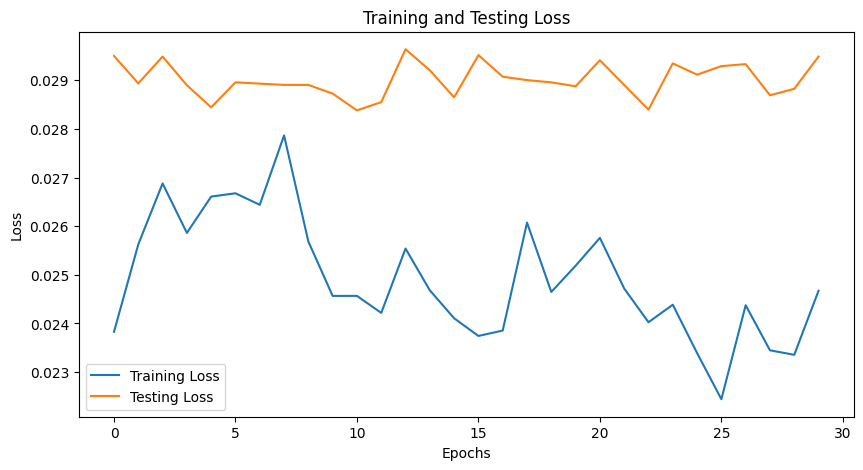

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
mse_lstm3 = mean_squared_error(Y_test,test_predict)
mae_lstm3 = mean_absolute_error(Y_test,test_predict)
mape_lstm3 = mean_absolute_percentage_error(Y_test,test_predict)*100

print(f'X_test MSE: {mse_lstm3}')
print(f'X_test MAE: {mae_lstm3}')
print('X_test MAPE:{}%'.format(mape_lstm3))

X_test MSE: 0.029246681135872303
X_test MAE: 0.1429180228810089
X_test MAPE:37.26957094657827%


In [ ]:
test_predict

array([[0.44050148],
       [0.45182836],
       [0.47014633],
       [0.49930078],
       [0.52886677],
       [0.5705811 ],
       [0.5969909 ],
       [0.60186327],
       [0.6013155 ],
       [0.5774301 ],
       [0.5493373 ],
       [0.518883  ],
       [0.5140667 ],
       [0.5395566 ],
       [0.4986281 ],
       [0.48799512],
       [0.5220202 ],
       [0.53692544],
       [0.54846144],
       [0.5670524 ],
       [0.57690054],
       [0.59322363],
       [0.6034008 ],
       [0.5777575 ],
       [0.58345824],
       [0.6021073 ],
       [0.58396566],
       [0.595187  ],
       [0.60610783],
       [0.5699271 ],
       [0.55309314],
       [0.534223  ],
       [0.5386986 ],
       [0.5643167 ],
       [0.5898943 ],
       [0.60877746],
       [0.64253193],
       [0.66015446],
       [0.6614425 ],
       [0.64338315],
       [0.6121375 ],
       [0.59459955],
       [0.5752989 ],
       [0.5460738 ],
       [0.5074094 ],
       [0.49982914],
       [0.49854475],
       [0.518

In [ ]:
len(test_predict)

233

In [ ]:
test_tavg_last = test['Tavg_pred'][len(test['Tavg_pred'])-len(test_predict):]
test_tavg_last = np.array(test_tavg_last)
test_tavg_last

array([27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11059466,
       27.11059466, 27.11059466, 27.11059466, 27.11059466, 27.11

In [ ]:
forecast_inverse = scaler.inverse_transform(test_predict)

In [ ]:
forecast_inverse

array([[-2.99535334e-01],
       [-2.34976172e-01],
       [-1.30570337e-01],
       [ 3.55995558e-02],
       [ 2.04115078e-01],
       [ 4.41871643e-01],
       [ 5.92398047e-01],
       [ 6.20168865e-01],
       [ 6.17046833e-01],
       [ 4.80908781e-01],
       [ 3.20789933e-01],
       [ 1.47211134e-01],
       [ 1.19759992e-01],
       [ 2.65043408e-01],
       [ 3.17655914e-02],
       [-2.88386457e-02],
       [ 1.65092230e-01],
       [ 2.50046581e-01],
       [ 3.15797657e-01],
       [ 4.21759576e-01],
       [ 4.77890313e-01],
       [ 5.70926070e-01],
       [ 6.28932416e-01],
       [ 4.82774556e-01],
       [ 5.15266895e-01],
       [ 6.21559739e-01],
       [ 5.18158972e-01],
       [ 5.82116604e-01],
       [ 6.44361377e-01],
       [ 4.38144177e-01],
       [ 3.42196673e-01],
       [ 2.34643802e-01],
       [ 2.60153085e-01],
       [ 4.06166881e-01],
       [ 5.51950037e-01],
       [ 6.59577310e-01],
       [ 8.51965666e-01],
       [ 9.52407777e-01],
       [ 9.5

In [ ]:
#Penambahan data prediksi ARIMA dan prediksi residual LSTM
predicted_tavg = [0 for _ in range(len(test_predict))]
for i in range(len(forecast_inverse)):
  predicted_tavg[i] = forecast_inverse[i][0]+test_tavg_last[i]

predicted_tavg

[26.811059330598837,
 26.875618492261893,
 26.980024327532774,
 27.146194220529324,
 27.3147097425623,
 27.552466307775504,
 27.702992712156302,
 27.730763529436118,
 27.727641497747427,
 27.59150344599915,
 27.43138459791375,
 27.257805799142844,
 27.23035465647412,
 27.3756380723877,
 27.142360256062275,
 27.08175601904226,
 27.275686894552237,
 27.36064124573899,
 27.42639232148362,
 27.53235424031449,
 27.58848497738076,
 27.681520734922415,
 27.739527081148154,
 27.593369220392233,
 27.625861560003287,
 27.73215440382195,
 27.628753636972434,
 27.692711268560416,
 27.754956041471488,
 27.548738841907507,
 27.45279133786393,
 27.345238466755873,
 27.37074774970246,
 27.516761546031958,
 27.662544702188498,
 27.770171974794394,
 27.962560330526358,
 28.063002442018515,
 28.070343886510855,
 27.96741196979714,
 27.789323006765372,
 27.689362977640158,
 27.579356228010184,
 27.41278362740708,
 27.192410421566493,
 27.14920571540428,
 27.14188514743877,
 27.255315949217803,
 27.1933120

In [ ]:
#Dataframe data aktual dan hasil prediksi hybrid ARIMA LSTM
df_aktual = pd.DataFrame(test['Tavg'][len(test['Tavg'])-len(test_predict):])
df_aktual['Tavg_pred']=predicted_tavg
df_aktual

,Tavg,Tavg_pred
Tanggal,,
2023-09-11,27.7,26.811059
2023-09-12,27.9,26.875618
2023-09-13,28.4,26.980024
2023-09-14,28.5,27.146194
2023-09-15,29.2,27.314710
...,...,...
2024-04-26,29.2,27.585255
2024-04-27,29.2,27.739749
2024-04-28,29.5,27.889927


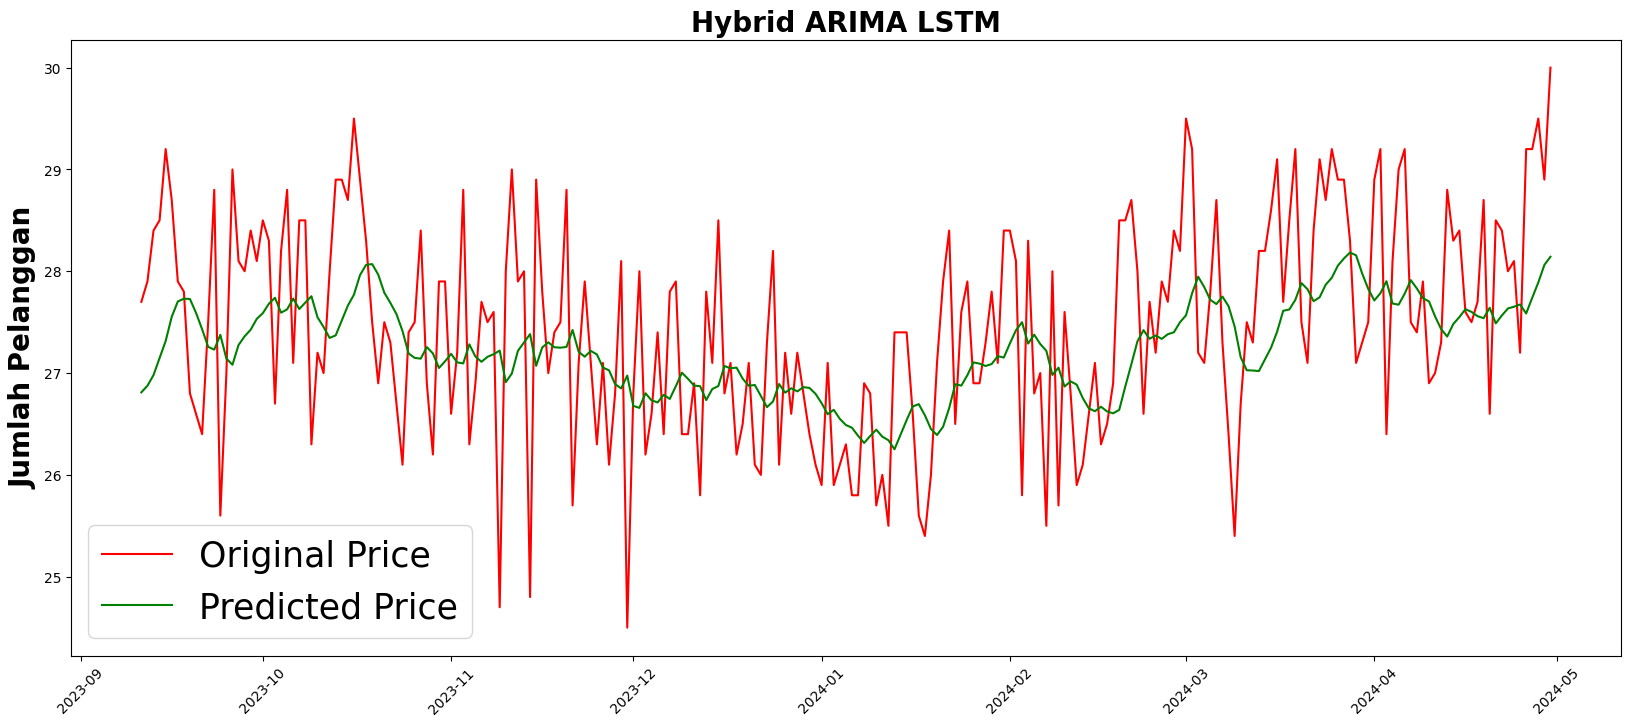

In [ ]:
#Plot hybrid ARIMA LSTM
plt.figure(figsize=(20,8))
plt.plot(df_aktual['Tavg'], label='Original Price', color='red')
plt.plot(df_aktual['Tavg_pred'], label='Predicted Price', color='green')
plt.title('Hybrid ARIMA LSTM', fontweight='bold', fontsize=20)
plt.ylabel('Jumlah Pelanggan', fontweight='bold', fontsize=20)
plt.xticks(rotation=45)
plt.legend(prop={'size':25})
plt.show()

In [ ]:
#Hasil Error dari Hybrid LSTM
mse3 = mean_squared_error(df_aktual['Tavg'],df_aktual['Tavg_pred'])
mae3 = mean_absolute_error(df_aktual['Tavg'],df_aktual['Tavg_pred'])
mape3 = mean_absolute_percentage_error(df_aktual['Tavg'],df_aktual['Tavg_pred'])*100

print(f'X_test MSE: {mse3}')
print(f'X_test MAE: {mae3}')
print('X_test MAPE:{}%'.format(mape3))

X_test MSE: 0.9501049606733009
X_test MAE: 0.8145814149129437
X_test MAPE:2.956639233924468%


Terjadi pengurangan MAPE dari model ARIMA sebelumnya

## Prediksi 1 Tahun Ke Depan

In [ ]:
step

21

In [ ]:
target_pred = 365

In [ ]:
initial_state = np.array(predicted_tavg.copy())

In [ ]:
for _ in range(len(forecast_inverse),len(forecast_inverse)+ target_pred):
  predicted_tavg.append(0)

In [ ]:
initial_state

array([26.81105933, 26.87561849, 26.98002433, 27.14619422, 27.31470974,
       27.55246631, 27.70299271, 27.73076353, 27.7276415 , 27.59150345,
       27.4313846 , 27.2578058 , 27.23035466, 27.37563807, 27.14236026,
       27.08175602, 27.27568689, 27.36064125, 27.42639232, 27.53235424,
       27.58848498, 27.68152073, 27.73952708, 27.59336922, 27.62586156,
       27.7321544 , 27.62875364, 27.69271127, 27.75495604, 27.54873884,
       27.45279134, 27.34523847, 27.37074775, 27.51676155, 27.6625447 ,
       27.77017197, 27.96256033, 28.06300244, 28.07034389, 27.96741197,
       27.78932301, 27.68936298, 27.57935623, 27.41278363, 27.19241042,
       27.14920572, 27.14188515, 27.25531595, 27.19331205, 27.05009602,
       27.11530115, 27.18890378, 27.10519127, 27.09502381, 27.28271172,
       27.16229243, 27.11102826, 27.15983384, 27.1854413 , 27.22100746,
       26.91074199, 26.99617469, 27.21852441, 27.30067435, 27.38299177,
       27.07152452, 27.25106362, 27.30245892, 27.25371585, 27.24

In [ ]:
forecast_resid = []

current = np.array(data_lstm[-len(test_predict):]).reshape(1, len(test_predict), 1)

for _ in range(target_pred):
    current_pred = model_lstm.predict(current,steps = step)
    forecast_resid.append(current_pred.flatten())
    current = np.append(current[: , 1:, :], [current_pred], axis = 1)

forecast_resid

21/21 [==============================] - 0s 872us/step


[array([1.4467779], dtype=float32),
 array([1.4291376], dtype=float32),
 array([1.4011902], dtype=float32),
 array([1.3589586], dtype=float32),
 array([1.3076568], dtype=float32),
 array([1.2515197], dtype=float32),
 array([1.1934023], dtype=float32),
 array([1.1352272], dtype=float32),
 array([1.0782914], dtype=float32),
 array([1.0234642], dtype=float32),
 array([0.9713171], dtype=float32),
 array([0.9222096], dtype=float32),
 array([0.87634593], dtype=float32),
 array([0.8338146], dtype=float32),
 array([0.7946173], dtype=float32),
 array([0.75868946], dtype=float32),
 array([0.7259179], dtype=float32),
 array([0.6961537], dtype=float32),
 array([0.66922355], dtype=float32),
 array([0.64493847], dtype=float32),
 array([0.62310183], dtype=float32),
 array([0.6035147], dtype=float32),
 array([0.5859811], dtype=float32),
 array([0.5703112], dtype=float32),
 array([0.5563241], dtype=float32),
 array([0.5438496], dtype=float32),
 array([0.53272957], dtype=float32),
 array([0.5228181], dt

In [ ]:
start_test=len(data_processing)
end_test= start_test + target_pred-1

forecast_arima = model_arima.predict(start = start_test, end = end_test)

In [ ]:
forecast = [resid + arima for resid, arima in zip(forecast_resid, forecast_arima)]

In [ ]:
len(forecast_arima)

365

In [ ]:
forecast = pd.DataFrame(forecast, index=forecast_arima.index)
forecast

,0
2024-05-01,28.557371
2024-05-02,28.539732
2024-05-03,28.511784
2024-05-04,28.469553
2024-05-05,28.418251
...,...
2025-04-26,27.543308
2025-04-27,27.543308
2025-04-28,27.543308
2025-04-29,27.543308


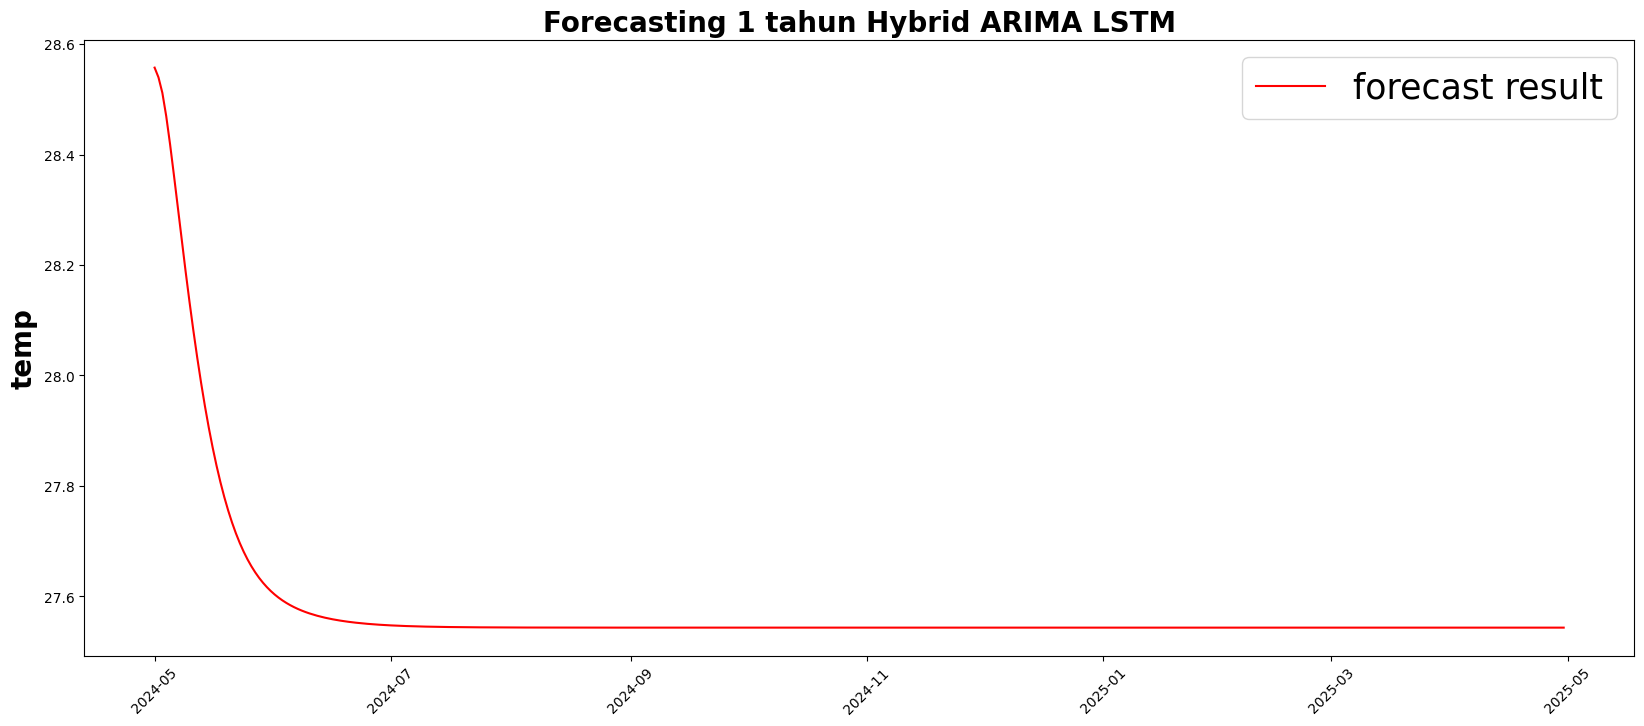

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(forecast, label='forecast result', color='red')
plt.title('Forecasting 1 tahun Hybrid ARIMA LSTM', fontweight='bold', fontsize=20)
plt.ylabel('temp', fontweight='bold', fontsize=20)
plt.xticks(rotation=45)
plt.legend(prop={'size':25})
plt.show()

In [ ]:
forecast

,0
2024-05-01,28.557371
2024-05-02,28.539732
2024-05-03,28.511784
2024-05-04,28.469553
2024-05-05,28.418251
...,...
2025-04-26,27.543308
2025-04-27,27.543308
2025-04-28,27.543308
2025-04-29,27.543308


# Kesimpulan

In [ ]:
#Hasil metrik
metrics_list = {
    'Data split': ['80:20', '70:30', '60:40'],
    'Hybrid ARIMA MAPE': [mape1, mape2, mape3],
    'Hybrid ARIMA MSE': [mse1, mse2, mse3],
    'Hybrid ARIMA MAE': [mae1, mae2, mae3],
    'ARIMA MAPE': [mape_arima1, mape_arima2, mape_arima3],
    'ARIMA MSE': [mse_arima1, mse_arima2, mse_arima3],
    'ARIMA MAE': [mae_arima1, mae_arima2, mae_arima3]
}

df_metrics = pd.DataFrame(metrics_list)
df_metrics = df_metrics.transpose()
df_metrics

,0,1,2
Data split,80:20,70:30,60:40
Hybrid ARIMA MAPE,3.086578,2.887959,2.956639
Hybrid ARIMA MSE,1.067096,0.884645,0.950105
Hybrid ARIMA MAE,0.88118,0.798164,0.814581
ARIMA MAPE,3.193018,3.234951,3.0805
ARIMA MSE,1.15448,1.16146,1.067641
ARIMA MAE,0.883949,0.884913,0.835222


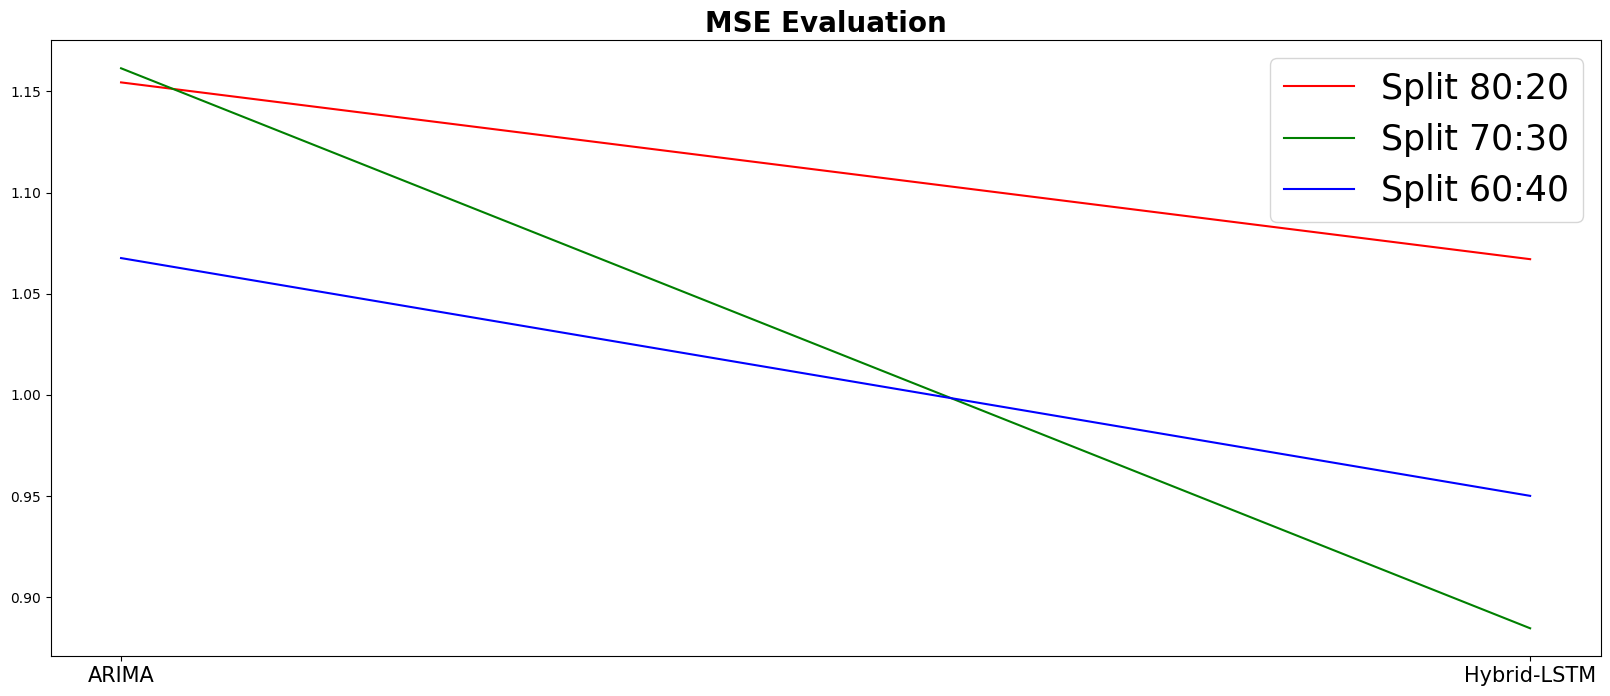

In [ ]:
plt.figure(figsize=(20,8))
plt.plot([mse_arima1,mse1], label='Split 80:20', color='red')
plt.plot([mse_arima2,mse2], label='Split 70:30', color='green')
plt.plot([mse_arima3,mse3], label='Split 60:40', color='blue')
plt.title('MSE Evaluation', fontweight='bold', fontsize=20)
plt.xticks(ticks=[0, 1], labels=['ARIMA', 'Hybrid-LSTM'], fontsize=15)
plt.legend(prop={'size':25})
plt.show()

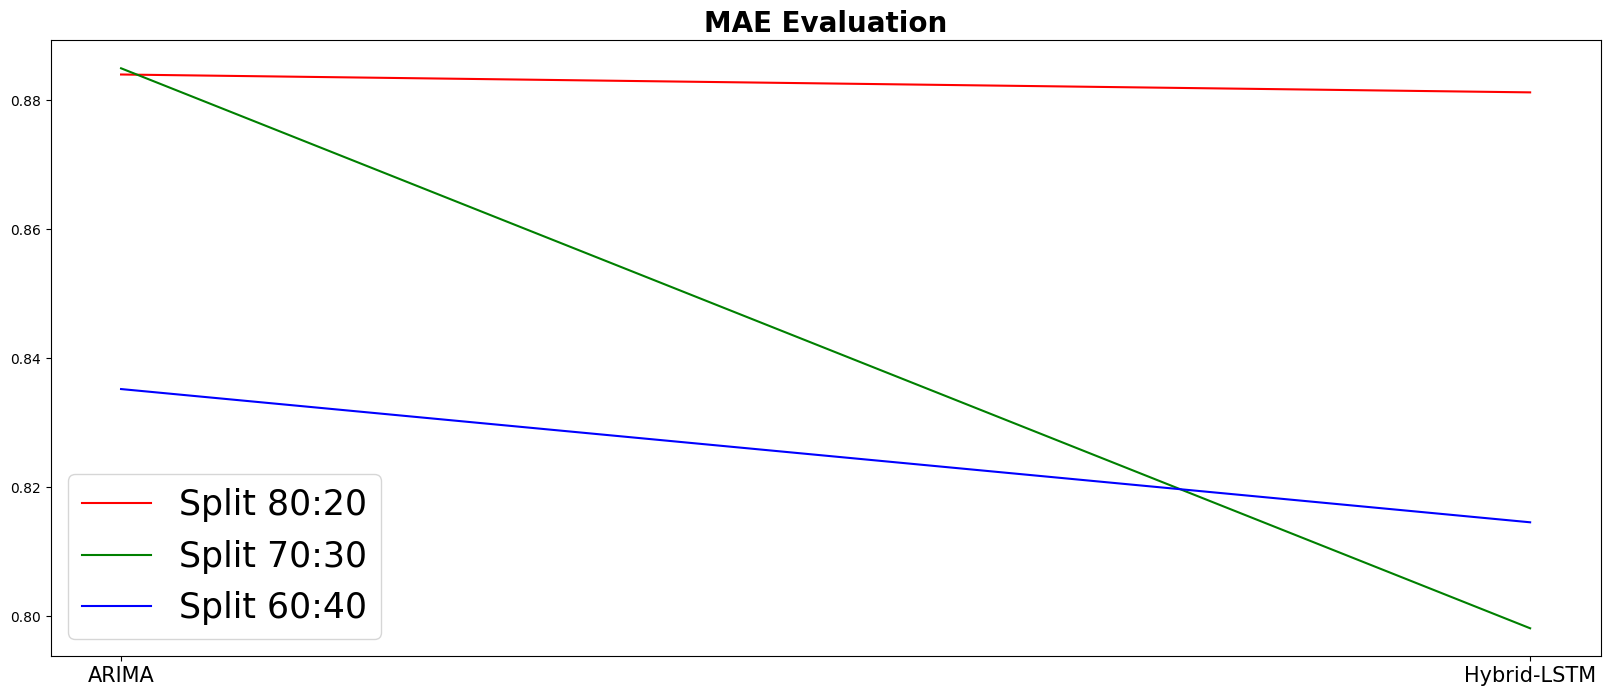

In [ ]:
plt.figure(figsize=(20,8))
plt.plot([mae_arima1,mae1], label='Split 80:20', color='red')
plt.plot([mae_arima2,mae2], label='Split 70:30', color='green')
plt.plot([mae_arima3,mae3], label='Split 60:40', color='blue')
plt.title('MAE Evaluation', fontweight='bold', fontsize=20)
plt.xticks(ticks=[0, 1], labels=['ARIMA', 'Hybrid-LSTM'], fontsize=15)
plt.legend(prop={'size':25})
plt.show()

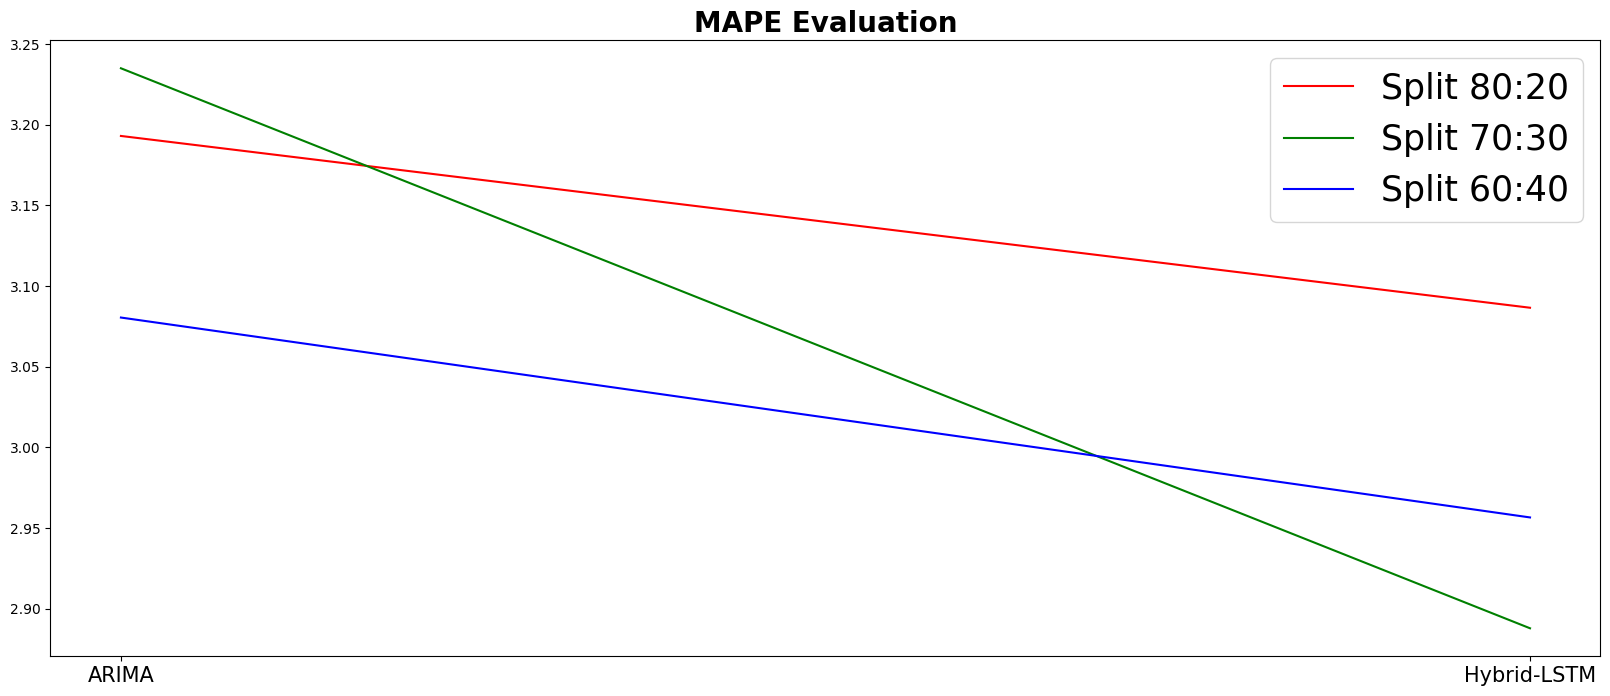

In [ ]:
plt.figure(figsize=(20,8))
plt.plot([mape_arima1,mape1], label='Split 80:20', color='red')
plt.plot([mape_arima2,mape2], label='Split 70:30', color='green')
plt.plot([mape_arima3,mape3], label='Split 60:40', color='blue')
plt.title('MAPE Evaluation', fontweight='bold', fontsize=20)
plt.xticks(ticks=[0, 1], labels=['ARIMA', 'Hybrid-LSTM'], fontsize=15)
plt.legend(prop={'size':25})
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2e3ead14-e1d1-4af7-8e7d-cb73e3d3639d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>